# Выпускной проект. Промышленность.

## Формулировка цели исследования и инициализация данных

### Описание проекта и загрузка данных

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:
- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Вижу твое добавленное описание проекта. Молодец! Это поможет тебе расставлять акценты в выводах.

**Загрузка данных**

Импортируем необходимые библиотеки и загрузим данные из CSV-файлов:

In [1]:
from catboost import CatBoostRegressor
from IPython.display import display, HTML
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import numpy as np
import pandas as pd
from xgboost import XGBRegressor

RANDOM_STATE = 170723

In [2]:
try:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_arc = pd.read_csv('data_arc_new.csv')
    data_bulk = pd.read_csv('data_bulk_new.csv')
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
    data_gas = pd.read_csv('data_gas_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv')
    data_wire = pd.read_csv('data_wire_new.csv')
    data_wire_time = pd.read_csv('data_wire_time_new.csv')

### Определение цели исследования и плана работы

**Целью данного проекта** является создание эффективной модели машинного обучения, способной предсказывать температуру стали в процессе обработки на основании данных из различных этапов этого процесса. Понимание взаимосвязи между процессом обработки и температурой стали позволит оптимизировать производственные затраты, уменьшив потребление электроэнергии. Для достижения этой цели, предлагаем следующий план работы:
1. **Исследовательский анализ данных (EDA):** Понимание природы данных, включая проверку пропущенных значений, выбросов и распределения признаков. Это поможет определить, требуются ли дополнительные этапы предобработки данных.
2. **Предварительная обработка данных:** На основе EDA мы можем провести предварительную обработку данных, включая заполнение пропущенных значений, обработку выбросов и нормализацию признаков.
3. **Построение и обучение моделей:** Этот шаг включает в себя разделение данных на тренировочные и тестовые наборы, выбор подходящих моделей для обучения, обучение этих моделей и оценку их производительности.
4. **Оценка и выбор модели:** На основе результатов, полученных на предыдущем шаге, будет выбрана лучшая модель. Этот шаг также может включать в себя дополнительную настройку гиперпараметров для улучшения производительности модели.
5. **Подготовка отчета:** Формирование финального отчета, включающего анализ данных, результаты и выводы.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Хорошо, план корректный   

    
Дополнительные советы:    
    
- Пропуски в данных по материалам стоит заполнить нулями
    
- При объединении данных по ключу используем INNER (т.е. берем только те партии, которые представлены во всех таблицах)
 
- После получения итогового датафрейма с признаками нужно провести его исследование (вывести графики распределения признаков)   
    
- Перед обучением моделей стоит исследовать матрицу кореляций признаков   
    
- Добавить анализ важности признаков для модели-победителя (+вывод по важности) и проверку модели на адекватность с помощью константной модели.
    
    
Более подробно вопросы рассмотрены на вебинаре      
</div>

## Исследовательский анализ данных

### Основная информация

In [3]:
datasets = {
    'data_arc': [data_arc, 'Данные об электродах'],
    'data_bulk': [data_bulk, 'Данные о подаче сыпучих материалов (объём)'],
    'data_bulk_time': [data_bulk_time, 'Данные о подаче сыпучих материалов (время)'],
    'data_gas': [data_gas, 'Данные о продувке сплава газом'],
    'data_temp': [data_temp, 'Результаты измерения температуры'],
    'data_wire': [data_wire, 'Данные о проволочных материалах (объём)'],
    'data_wire_time': [data_wire_time, 'Данные о проволочных материалах (время)']
}

for name, (dataset, description) in datasets.items():
    display(HTML(f"<h4 style='color: blue;'>{description} ({name}):</h4>"))
    display(dataset.head(10))
    display(dataset.info())
    missing_data = (dataset.isnull().sum() / len(dataset)) * 100
    display(missing_data)
    display(dataset.describe())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

key      0.0
Газ 1    0.0
dtype: float64

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

key              0.000000
Время замера     0.000000
Температура     18.942074
dtype: float64

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Данные представляют из себя набор таблиц, содержащих разнообразную информацию о процессе металлургического производства, включая данные об электродах, подаче сыпучих материалов, продувке сплава газом и измерениях температуры. Исходя из представленной информации, можно сделать следующие предварительные замечания:

- таблица `data_arc` содержит данные о нагреве сплава электродами. Каждая строка отражает отдельный цикл нагрева: его начало и конец, а также активную и реактивную мощность, потребленную в процессе;
- `data_bulk` содержит информацию об объеме каждого из сыпучих материалов (обозначенных как "Bulk" с соответствующим номером), которые были добавлены в сплав в процессе обработки. Данные по некоторым видам материалов отсутствуют для большинства партий (много пропущенных значений), что может указывать на то, что эти виды материалов используются редко или в определенных условиях. Также важно отметить, что различные материалы могут вносить разный вклад в конечное качество продукта;
- `data_bulk_time` отражает время добавления каждого из сыпучих материалов в сплав;
- в таблице `data_gas` указано количество газа, использованного для продувки сплава после его обработки. У каждого ключа есть значение объема газа;
- в `data_temp` представлены результаты измерения температуры сплава в различные моменты времени. Каждая запись содержит время замера и значение температуры. У каждого ключа есть несколько замеров температуры в разные моменты времени. Первый замер - начальная температура, последний - конечная температура.

Важно понимать, какие из этих данных наиболее важны для нашей задачи. Некоторые из возможных подходов:
1. **Объединение данных:** Можно объединить все эти наборы данных в один большой датафрейм, используя `key` в качестве общего ключа. Это будет удобно для анализа связей между различными типами данных.
2. **Обработка пропущенных значений:** Некоторые датафреймы содержат большое количество пропущенных значений. Нам необходимо решить, как их обрабатывать - заполнять некоторыми значениями (например, средним), удалять или использовать какие-то другие подходы.
3. **Извлечение признаков:** Мы можем извлечь различные признаки из представленных данных. Например, из `data_arc` мы можем извлечь длительность каждого периода нагрева, а из `data_temp` - разницу между начальной и конечной температурой для каждого ключа.

### Данные об электродах (data_arc)

Переименуем столбцы на английский язык для облегчения процесса обработки данных и повышения совместимости с различными библиотеками и инструментами. Перед внесением изменений в датафрейм, создадим его копию.

In [4]:
df_arc = data_arc.copy()

df_arc = df_arc.rename(columns={
    'Начало нагрева дугой': 'start_of_heating',
    'Конец нагрева дугой': 'end_of_heating',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power'
})

Построим горизонтальные "ящики с усами" отдельно для активной и реактивной мощности.

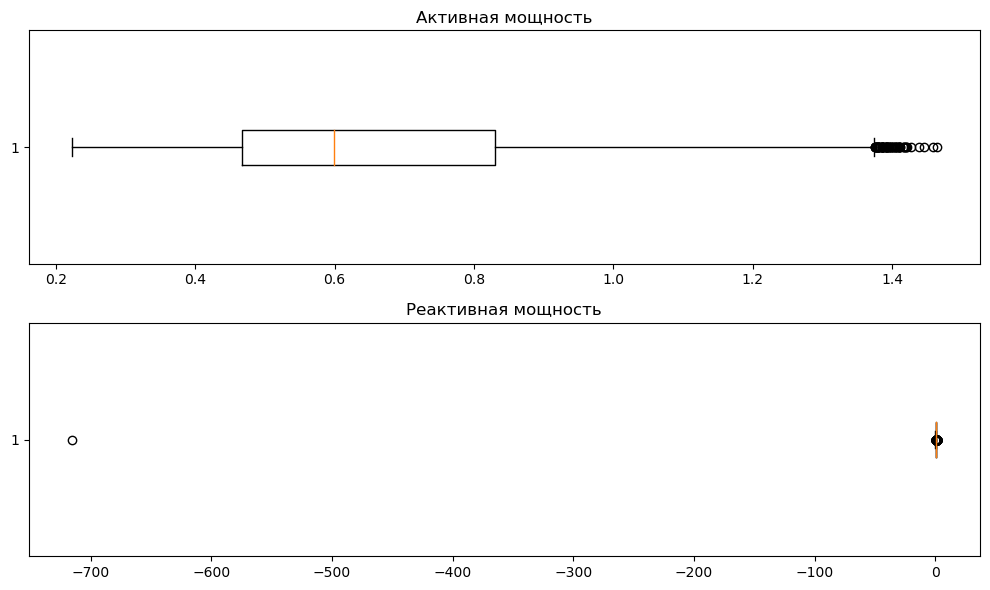

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))
axs[0].boxplot(df_arc['active_power'], vert=False)
axs[0].set_title('Активная мощность')

axs[1].boxplot(df_arc['reactive_power'], vert=False)
axs[1].set_title('Реактивная мощность')

fig.tight_layout()
plt.show()

Рассмотрим строчки с выбросами в графике, которые имеют отрицательное значение реативной мощности меньше 700. 

In [6]:
df_arc[df_arc['reactive_power'] < -700]

,key,start_of_heating,end_of_heating,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Похоже, что это выброс. Реактивная мощность не должна быть отрицательной, так как она отражает потерю энергии в системе, которая является положительной величиной. Так как такой выброс не является репрезентативным и его удаление не повлияет на общие выводы из анализа, то его можно безопасно удалить.

In [7]:
df_arc = df_arc[df_arc['reactive_power'] >= 0]

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Отлично, что удалено наблюдение с отрицательной реактивной мощностью

Преобразуем колонки в формат даты и времени и создадим новый столбец `heating_time`, который будет содержать время нагрева в секундах.

,key,start_of_heating,end_of_heating,active_power,reactive_power,heating_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148


count    14875.000000
mean       171.675160
std         98.188759
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: heating_time, dtype: float64

<AxesSubplot:>

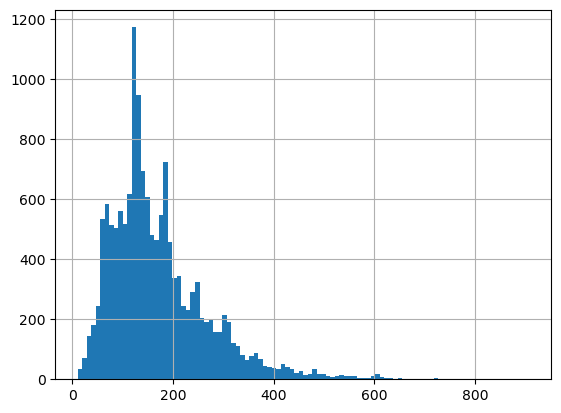

In [8]:
df_arc['start_of_heating'] = pd.to_datetime(df_arc['start_of_heating'])
df_arc['end_of_heating'] = pd.to_datetime(df_arc['end_of_heating'])

df_arc['heating_time'] = df_arc['end_of_heating'] - df_arc['start_of_heating']
df_arc['heating_time'] = df_arc['heating_time'].dt.total_seconds()
df_arc['heating_time'] = df_arc['heating_time'].astype('int')

display(df_arc.head())
display(df_arc['heating_time'].describe())
df_arc['heating_time'].hist(bins=100)

На гистограмме можно увидеть, что большинство значений лежит в диапазоне от около 100 до 200 секунд, но есть и более длительные периоды нагрева. Время нагрева в электроплавильных печах может значительно варьироваться из-за множества факторов, например, большие куски металла требуют больше времени для нагрева, чем мелкие.

Полная мощность в электрической цепи рассчитывается по формуле:

$$
S = \sqrt{P^2 + Q^2}
$$
где:

- S - полная мощность;
- P - активная мощность;
- Q - реактивная мощность.

Рассчитаем значение полной мощности в нашем датафрейме, которое мы будем использовать при вычисления энергии, потребляемой в процессе нагрева.

In [9]:
df_arc['full_power'] = (df_arc['active_power']**2 + df_arc['reactive_power']**2)**0.5

Энергию можно вычислить как произведение полной мощности на время. 

In [10]:
df_arc['energy'] = df_arc['full_power'] * df_arc['heating_time']
df_arc.sample(10)

,key,start_of_heating,end_of_heating,active_power,reactive_power,heating_time,full_power,energy
8076,1753,2019-07-07 15:50:47,2019-07-07 15:53:27,0.473073,0.397509,160,0.617909,98.865432
5619,1221,2019-06-18 14:48:08,2019-06-18 14:49:55,0.504124,0.377062,107,0.629537,67.360453
4779,1031,2019-06-12 06:21:42,2019-06-12 06:22:54,0.452257,0.386359,72,0.594819,42.826970
11091,2414,2019-08-07 14:09:27,2019-08-07 14:14:08,0.482772,0.393932,281,0.623098,175.090562
6661,1450,2019-06-26 23:05:18,2019-06-26 23:07:33,0.509548,0.342443,135,0.613927,82.880146
14655,3188,2019-09-04 21:11:03,2019-09-04 21:12:41,0.339767,0.234251,98,0.412693,40.443870
9498,2061,2019-07-25 15:25:30,2019-07-25 15:28:17,0.605682,0.457226,167,0.758885,126.733779
14012,3044,2019-08-30 23:10:32,2019-08-30 23:12:30,0.420811,0.287051,118,0.509392,60.108252
13683,2967,2019-08-28 06:59:41,2019-08-28 07:02:10,0.862557,0.710851,149,1.117727,166.541328
13036,2834,2019-08-23 02:16:15,2019-08-23 02:18:25,0.438695,0.340343,130,0.555236,72.180638


Таким образом, после предобработки и анализа данных о электродах, мы обнаружили следующее:

- Большинство значений времени нагрева лежит в диапазоне от около 100 до 200 секунд. Это говорит о том, что большая часть операций по нагреву длится от 1,5 до 3 минут, что вполне соответствует стандартным технологическим процессам в электроплавильных печах.

- Мы вычислили полную мощность и энергию для каждого периода нагрева. Эти параметры являются важными для понимания энергетических характеристик процесса и могут иметь значимое влияние на конечное качество продукции.

- Мы обнаружили и удалили один выброс, где реактивная мощность была отрицательной. Такое значение несоответствует физической сущности реактивной мощности и явно указывает на ошибку измерения или записи данных.

### Данные о подаче материалов (data_bulk, data_wire)

Эти две таблицы предоставляют информацию о том, какие материалы и в каком объеме добавляются в каждый процесс.

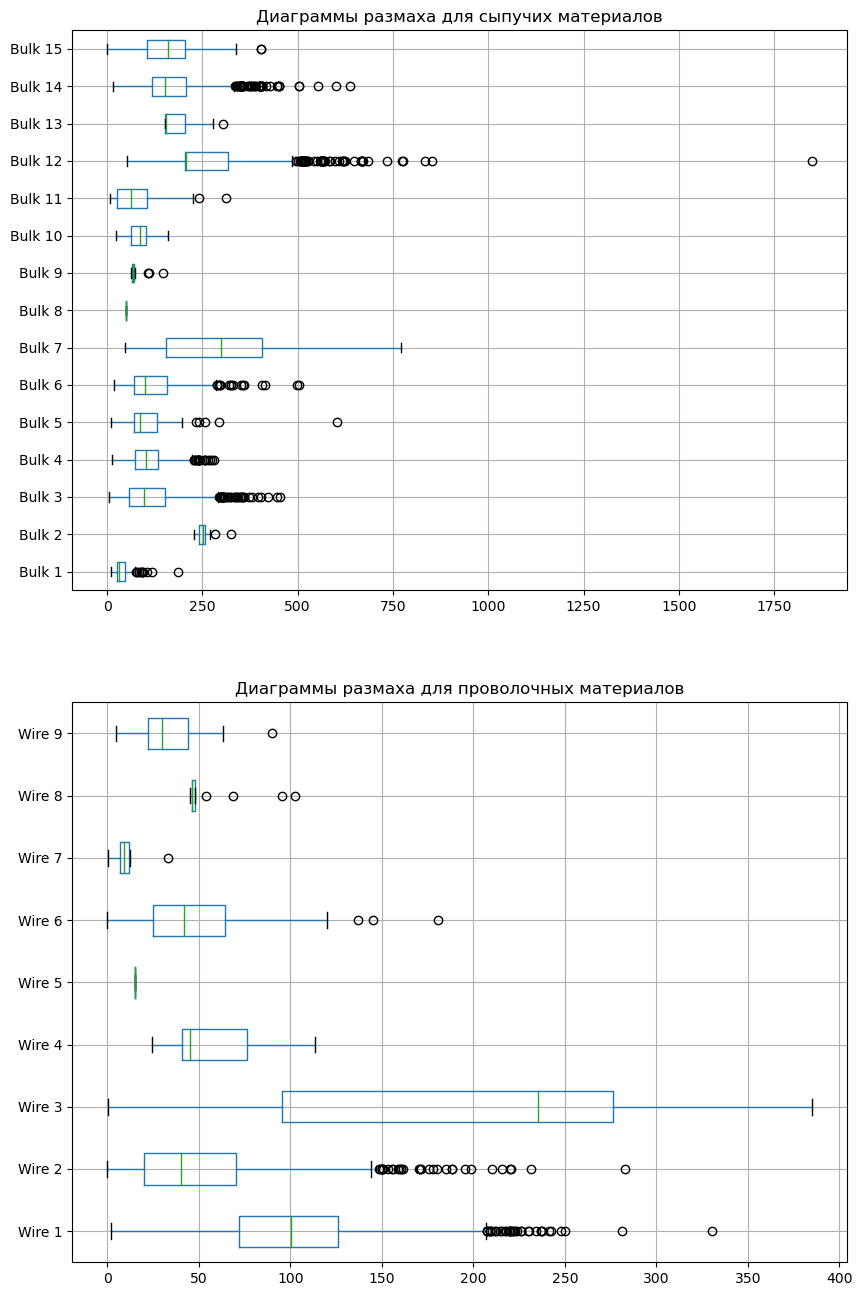

In [11]:
features_bulk = data_bulk.drop(columns=['key'])
features_wire = data_wire.drop(columns=['key'])

fig, ax = plt.subplots(2, 1, figsize=(10, 16))
features_bulk.boxplot(ax=ax[0], vert=False)
ax[0].set_title('Диаграммы размаха для сыпучих материалов')

features_wire.boxplot(ax=ax[1], vert=False)
ax[1].set_title('Диаграммы размаха для проволочных материалов')

plt.show()

Из графика видно, что почти все признаки содержат небольшие выбросы. Средние значения, стандартное отклонение, минимальные и максимальные значения, медианы и квартили показывают различную вариативность объемов каждого типа материалов. Это может указывать на различную важность каждого из них в процессе производства стали.

Большинство признаков содержат значительное количество пропущенных значений. Процент пропущенных значений варьируется от ~10% до ~99%. По-видимому, не все типы материалов (Bulk 1, Bulk 2, Wire 1, Wire 2 и т.д.) добавлялись в каждую партию стали.

Учитывая наш текущий подход к анализу данных, мы решили заполнить пропущенные значения нулями для удобства последующего анализа и моделирования. Мы можем пересмотреть этот подход после получения дополнительной информации или обратной связи от заказчика.

In [12]:
df_bulk = data_bulk.copy()
df_wire = data_wire.copy()
df_bulk.fillna(0, inplace=True)
df_wire.fillna(0, inplace=True)

### Данные о продувке сплава газом (data_gas)

Переименуем столбец с данными.

In [13]:
df_gas = data_gas.copy()
df_gas.rename(columns={'Газ 1': 'Gas_1'}, inplace=True)

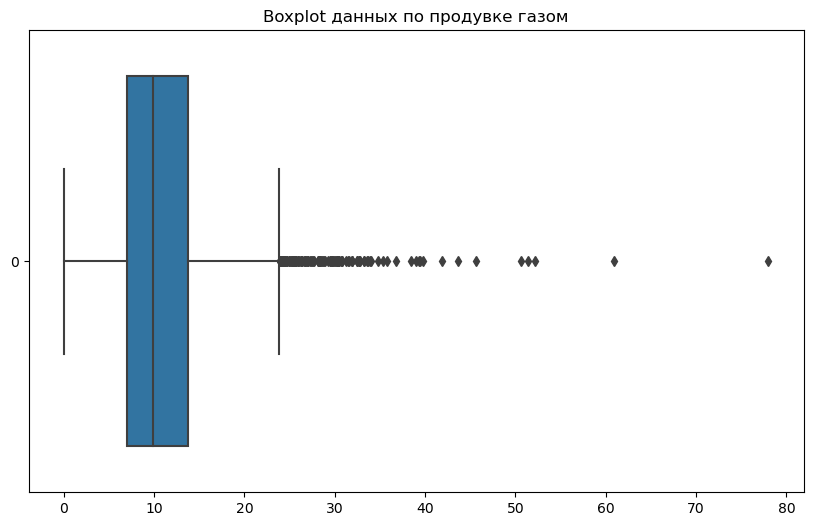

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_gas['Gas_1'], orient='h')
plt.title('Boxplot данных по продувке газом')
plt.show()

Если анализировать основные статистические параметры таблицы, то можно сказать следующее:

- Все 3239 записей в таблице полные, нет пропущенных значений, что означает, что для каждой партии имеется информация о продувке газом. 
- Минимальное значение использованного газа очень близко к 0, а максимальное - примерно 78 единицы, что указывает на значительные различия в объемах использованного газа.
- Медианное значение (или 50-й процентиль) составляет около 9.84, что ниже среднего значения, указывает на небольшую асимметрию данных вправо.

### Результаты измерения температуры (data_temp)

Данный датафрейм содержит данные с целевым признаком нашего исследования - измерением температуры для каждой партии стали.

Переименуем столбцы и приведем к формату даты и времени.

In [15]:
df_temp = data_temp.copy()
df_temp.rename(columns={'Время замера': 'measurement_time',
                        'Температура': 'temperature'}, inplace=True)
df_temp['measurement_time'] = pd.to_datetime(df_temp['measurement_time'])
df_temp.head(10)

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Пропущенные значения в столбце `temperature` могут указывать на то, что в некоторых партиях температуру не измеряли, либо эти данные были утеряны или не записаны. Удалим эти значения.

In [16]:
df_temp = df_temp.dropna()

В данных одному ключу `key` соответствуют несколько измерений температуры. Это говорит о том, что температуру сплава измеряли несколько раз в разные моменты времени в течение одного цикла обработки. Выделим первое и последнее значение замеров температуры для каждого ключа.


In [17]:
first_temp = df_temp.groupby('key').first()['temperature']
last_temp = df_temp.groupby('key').last()['temperature']

final_temp = pd.concat([first_temp, last_temp], axis=1)
final_temp.columns = ['first_temperature', 'last_temperature']

print(final_temp.head())
final_temp.shape

     first_temperature  last_temperature
key                                     
1               1571.0            1613.0
2               1581.0            1602.0
3               1596.0            1599.0
4               1601.0            1625.0
5               1576.0            1602.0


(3216, 2)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Целевой признак выбран корректно

In [18]:
final_temp.describe()

,first_temperature,last_temperature
count,3216.000000,3216.000000
mean,1588.592040,1593.928483
std,29.137454,19.874627
min,1191.000000,1204.000000
25%,1572.000000,1585.000000
50%,1588.000000,1593.000000
75%,1606.000000,1600.000000
max,1684.000000,1700.000000


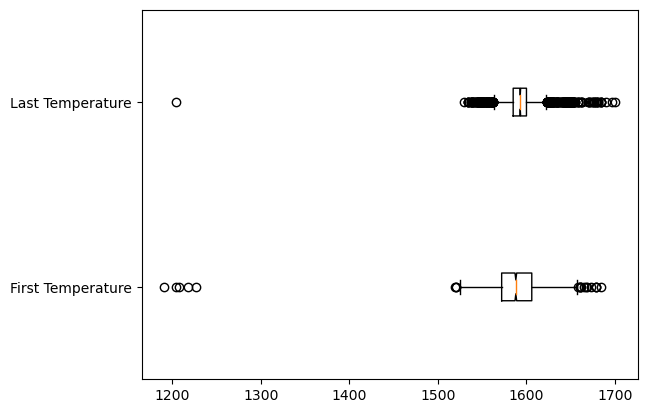

In [19]:
fig, ax = plt.subplots()
ax.boxplot([final_temp['first_temperature'].dropna(), final_temp['last_temperature'].dropna()], notch=True, vert=False)
ax.set_yticklabels(['First Temperature', 'Last Temperature'])

plt.show()

Значения около 1200 могут быть аномальными и возможно, требуют дополнительного исследования. Они могут быть результатом ошибок в данных, но также могут отражать реальные, но редкие события. Требуется уточнение от заказчика.

### Объединение таблиц

Для начала объединим данные в таблице `df_arc` по ключу, используя метод groupby в pandas.

In [20]:
df_arc_grouped = df_arc.groupby('key').agg({
    'heating_time': 'sum',
    'active_power': 'sum',
    'reactive_power': 'sum',
    'full_power': 'sum',
    'energy': 'sum'
}).reset_index()

df_arc_grouped

,key,heating_time,active_power,reactive_power,full_power,energy
0,1,1098,3.036730,2.142821,3.718736,770.282114
1,2,811,2.139408,1.453357,2.588349,481.760005
2,3,655,4.063641,2.937457,5.019223,722.837668
3,4,741,2.706489,2.056992,3.400038,683.455597
4,5,869,2.252950,1.687991,2.816980,512.169934
...,...,...,...,...,...,...
3209,3237,909,2.541872,2.025417,3.250657,630.503534
3210,3238,546,1.374821,1.038103,1.723937,286.052252
3211,3239,1216,4.848005,3.541541,6.014480,941.538764
3212,3240,839,3.317679,2.373552,4.082920,657.439848


Объединим остальные таблицы в финальный датасет.

In [21]:
merged_df = pd.merge(df_arc_grouped, final_temp, on='key', how='inner')
merged_df = pd.merge(merged_df, df_gas, on='key', how='inner') 
merged_df = pd.merge(merged_df, df_bulk, on='key', how='inner')
merged_df = pd.merge(merged_df, df_wire, on='key', how='inner')
merged_df

,key,heating_time,active_power,reactive_power,full_power,energy,first_temperature,last_temperature,Gas_1,Bulk 1,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1098,3.036730,2.142821,3.718736,770.282114,1571.0,1613.0,29.749986,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,811,2.139408,1.453357,2.588349,481.760005,1581.0,1602.0,12.555561,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,655,4.063641,2.937457,5.019223,722.837668,1596.0,1599.0,28.554793,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,741,2.706489,2.056992,3.400038,683.455597,1601.0,1625.0,18.841219,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,869,2.252950,1.687991,2.816980,512.169934,1576.0,1602.0,5.413692,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,3237,909,2.541872,2.025417,3.250657,630.503534,1569.0,1569.0,5.543905,0.0,...,206.0,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3018,3238,546,1.374821,1.038103,1.723937,286.052252,1584.0,1584.0,6.745669,0.0,...,106.0,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3019,3239,1216,4.848005,3.541541,6.014480,941.538764,1598.0,1598.0,16.023518,0.0,...,88.0,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3020,3240,839,3.317679,2.373552,4.082920,657.439848,1617.0,1617.0,11.863103,0.0,...,54.0,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Удалим партии, в которых первое измерение температуры равно последнему, так как это свидетельствует о том, что был произведен всего один замер. Эти данные не будут корректно представлять процесс обработки стали.

In [22]:
rows_before = merged_df.shape[0]

merged_df = merged_df[merged_df['first_temperature'] != merged_df['last_temperature']]

rows_after = merged_df.shape[0]

print("Количество удаленных строк:", rows_before - rows_after)

Количество удаленных строк: 729


In [23]:
merged_df.tail()

,key,heating_time,active_power,reactive_power,full_power,energy,first_temperature,last_temperature,Gas_1,Bulk 1,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2324,2495,723,3.168133,2.210936,3.868721,694.177326,1570.0,1591.0,7.125735,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,2496,940,4.174918,2.872031,5.070316,815.818538,1554.0,1591.0,9.412616,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,2497,569,3.605239,2.452092,4.360918,823.020520,1571.0,1589.0,6.271699,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,2498,750,3.202310,2.239820,3.909917,581.810739,1591.0,1594.0,14.953657,0.0,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2328,2499,883,1.737084,1.296836,2.169252,532.386183,1569.0,1603.0,11.336151,0.0,...,227.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
    
Нужно оставить только те партии,  для которых все замеры температуры известны (первый, последний замер). К примеру, если есть только один замер, то нам следует удалить такую партию целиком. Прежде чем удалять столбец ключ из датасета, следует убедиться, что лишние ключи были удалены (подсказка: если вывести `df.tail()`, то при правильном удалении не останется ключей >= 2500) Исправь, пожалуйста.
</div>

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Исправлено, в выводе нет ключей больше или равных 2500.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2328
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2293 non-null   int64  
 1   heating_time       2293 non-null   int32  
 2   active_power       2293 non-null   float64
 3   reactive_power     2293 non-null   float64
 4   full_power         2293 non-null   float64
 5   energy             2293 non-null   float64
 6   first_temperature  2293 non-null   float64
 7   last_temperature   2293 non-null   float64
 8   Gas_1              2293 non-null   float64
 9   Bulk 1             2293 non-null   float64
 10  Bulk 2             2293 non-null   float64
 11  Bulk 3             2293 non-null   float64
 12  Bulk 4             2293 non-null   float64
 13  Bulk 5             2293 non-null   float64
 14  Bulk 6             2293 non-null   float64
 15  Bulk 7             2293 non-null   float64
 16  Bulk 8             2293 

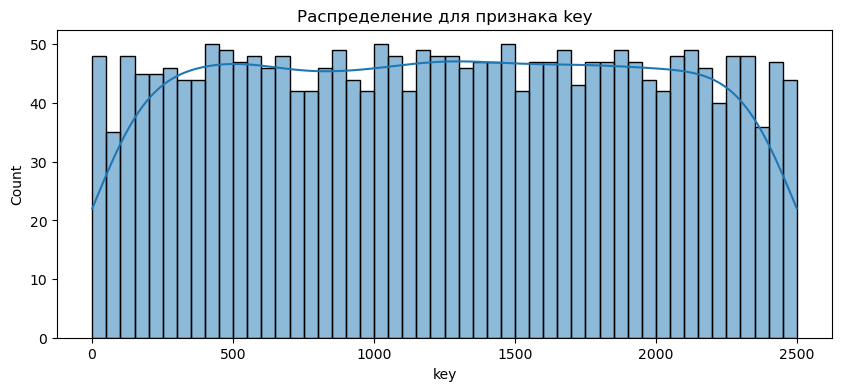

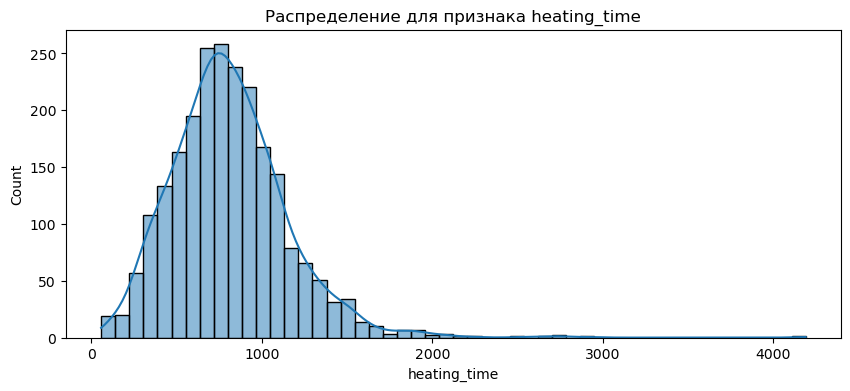

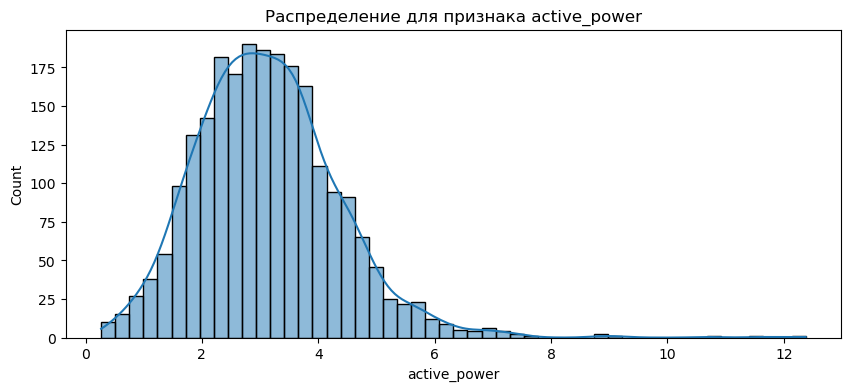

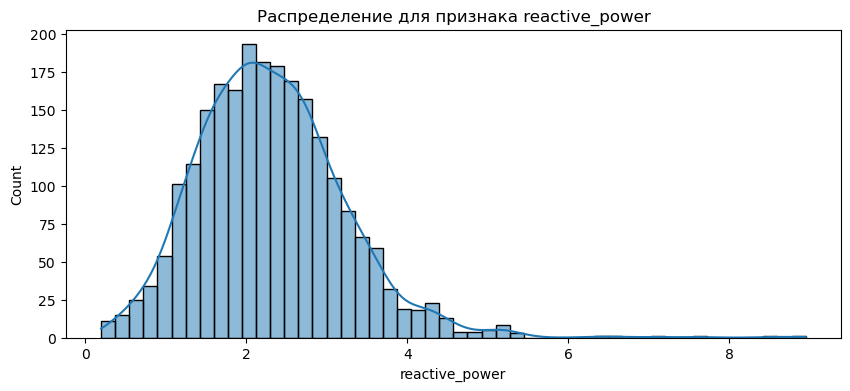

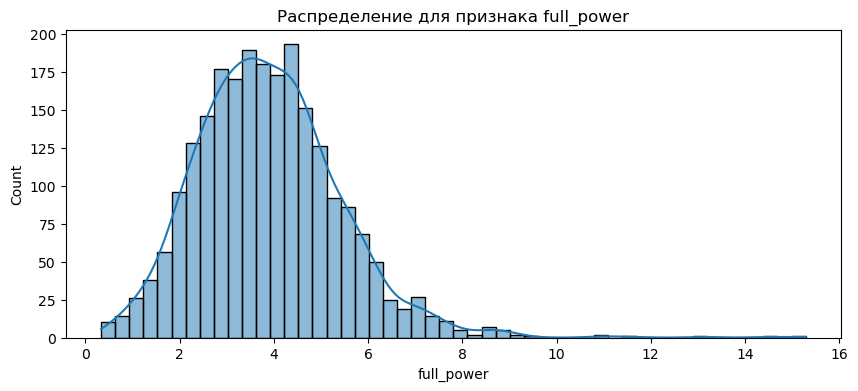

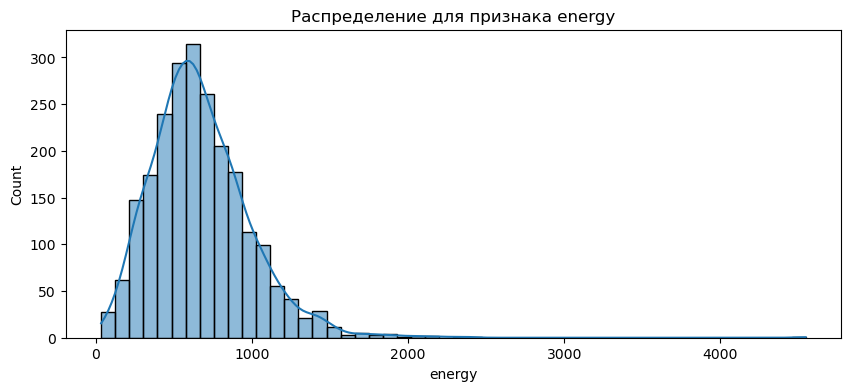

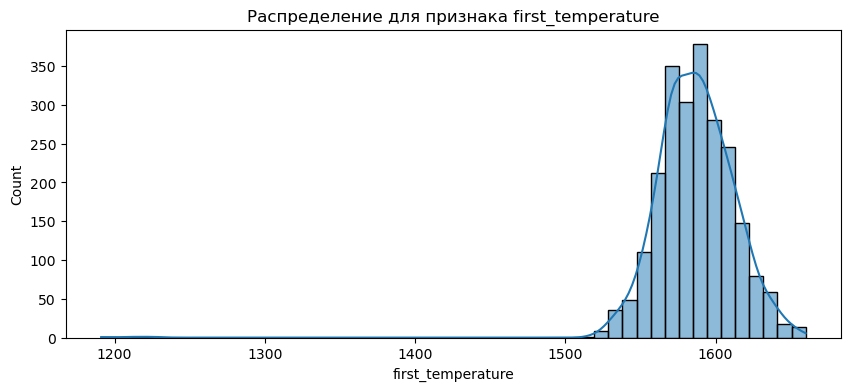

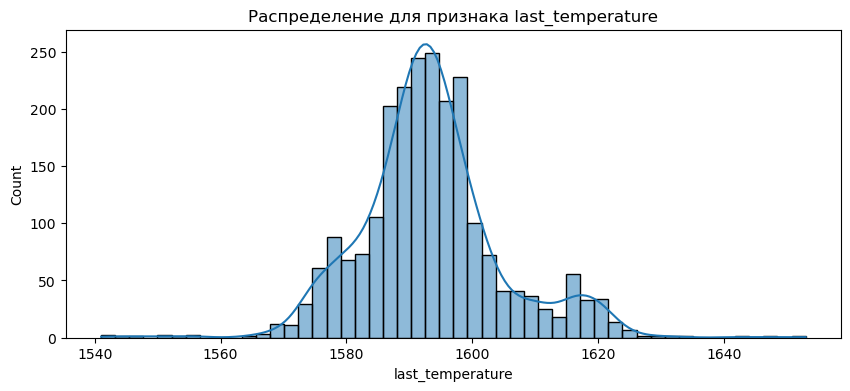

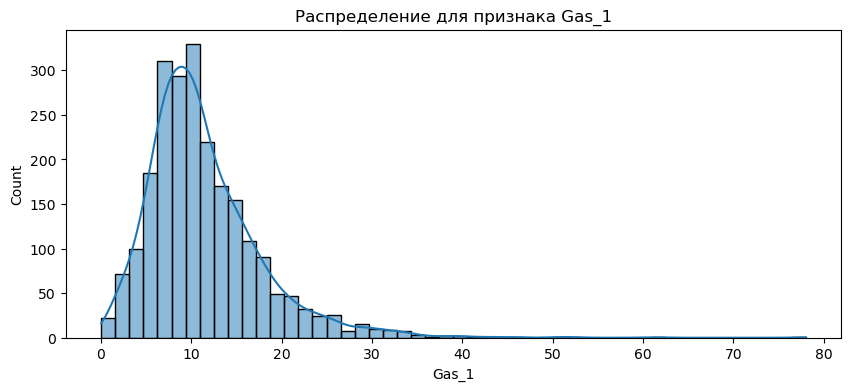

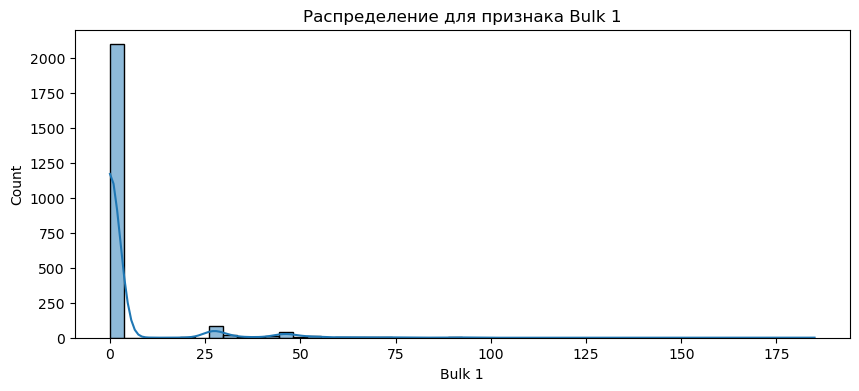

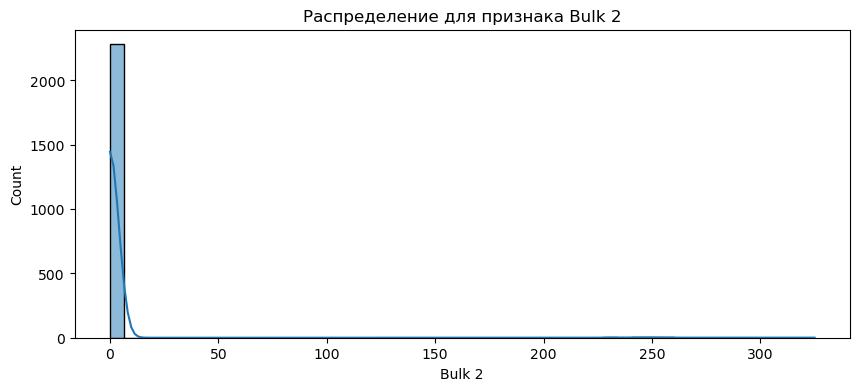

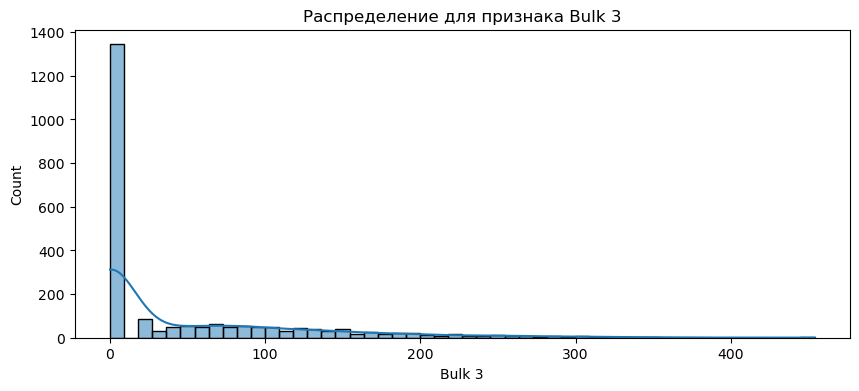

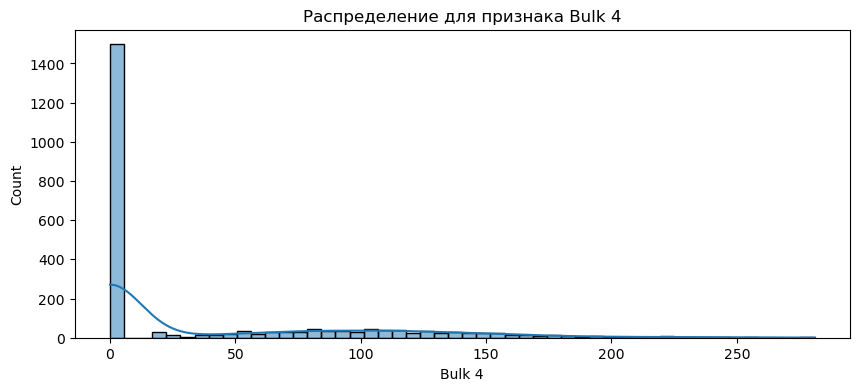

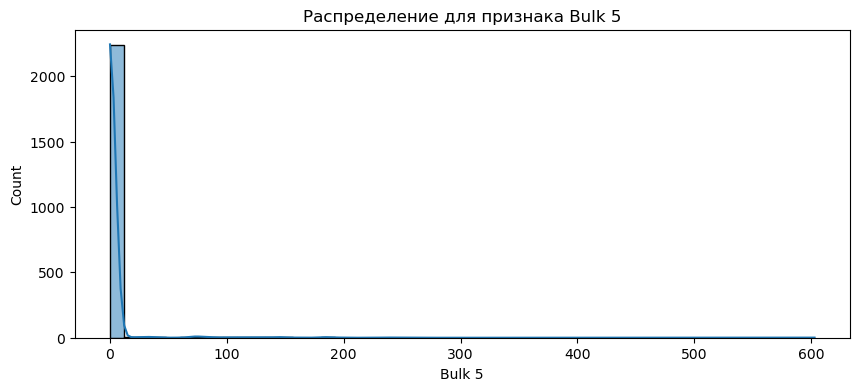

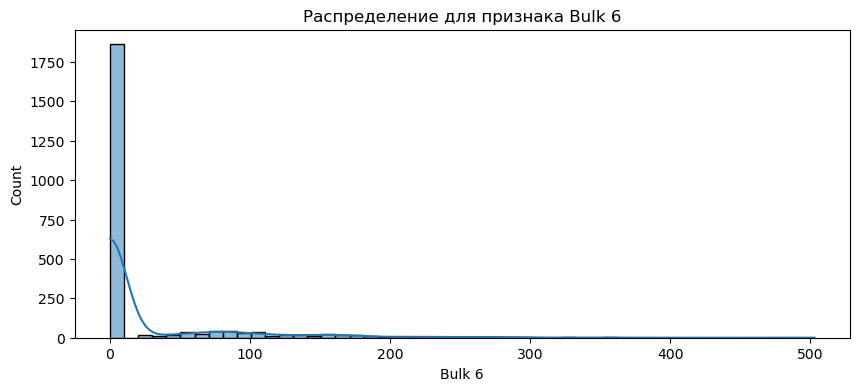

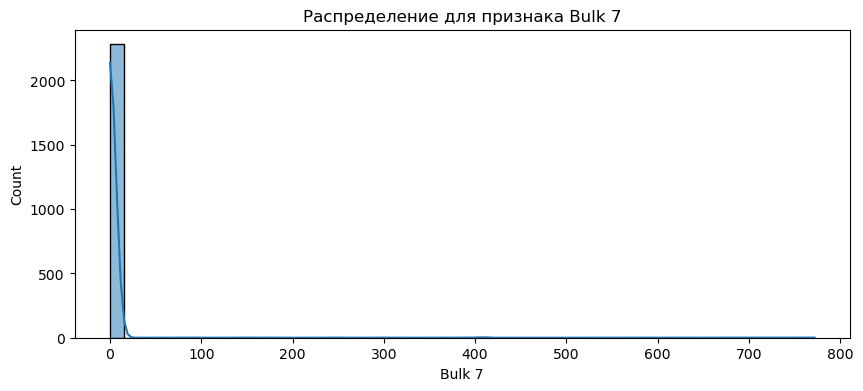

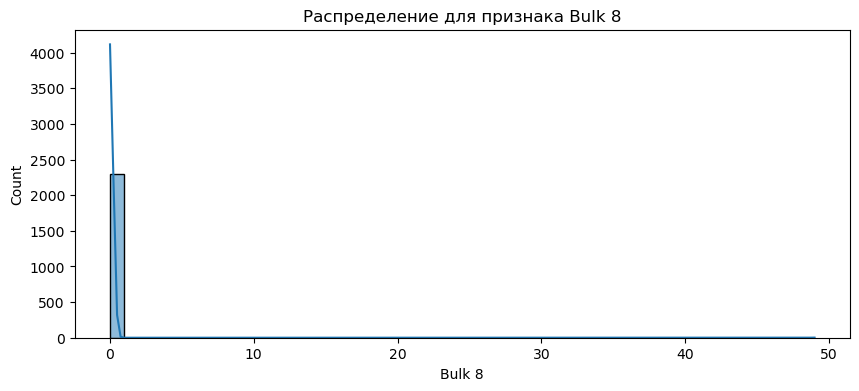

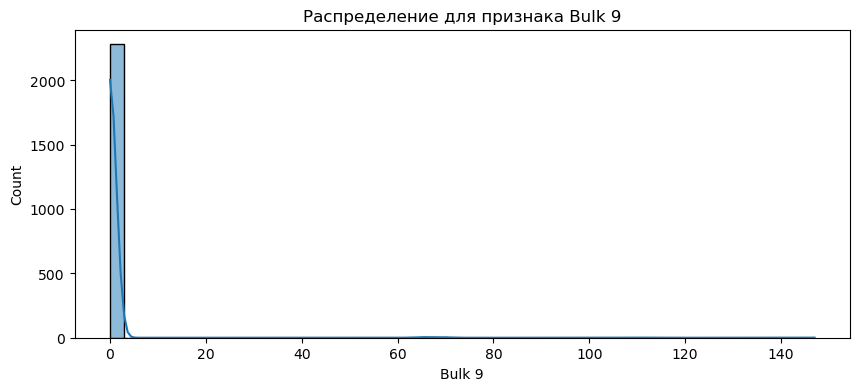

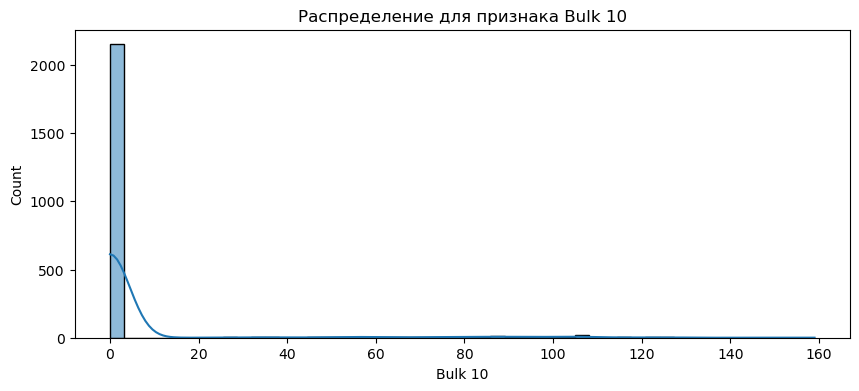

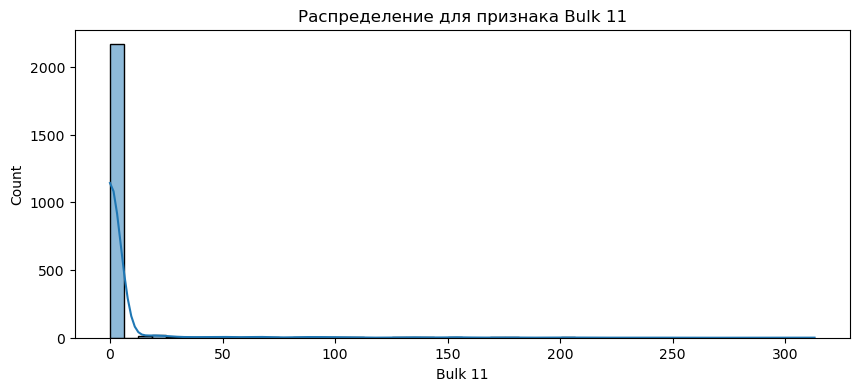

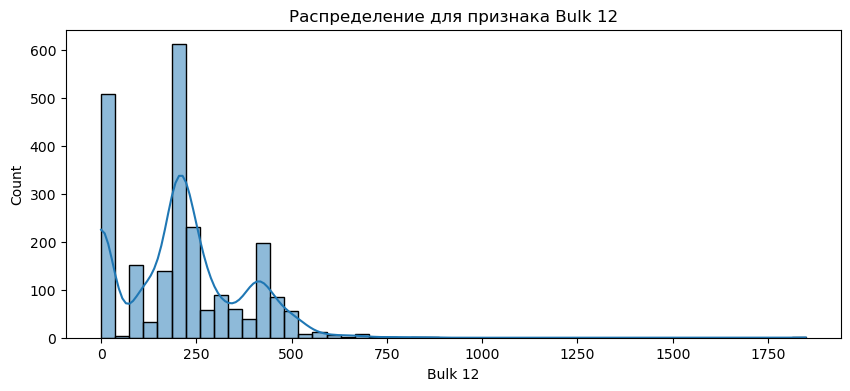

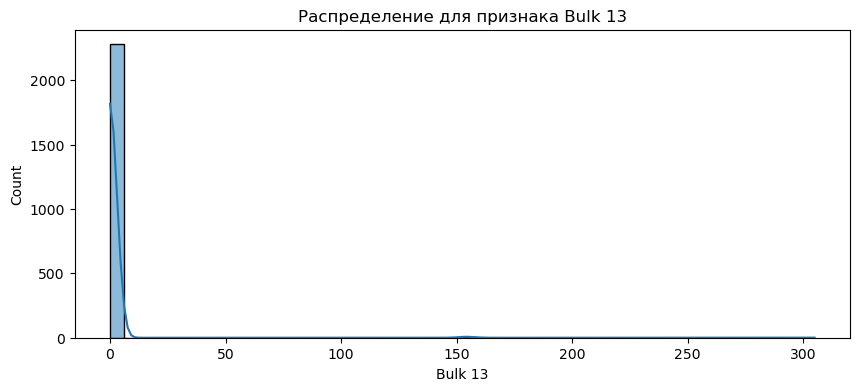

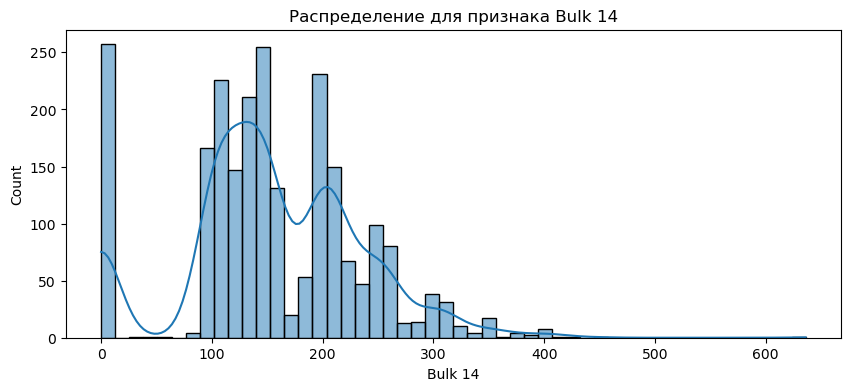

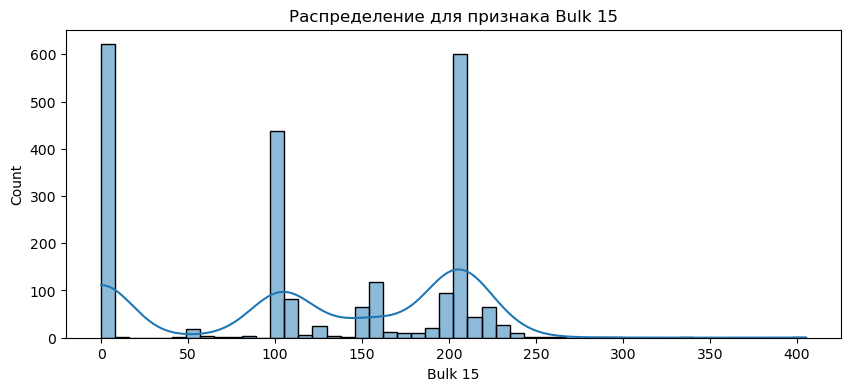

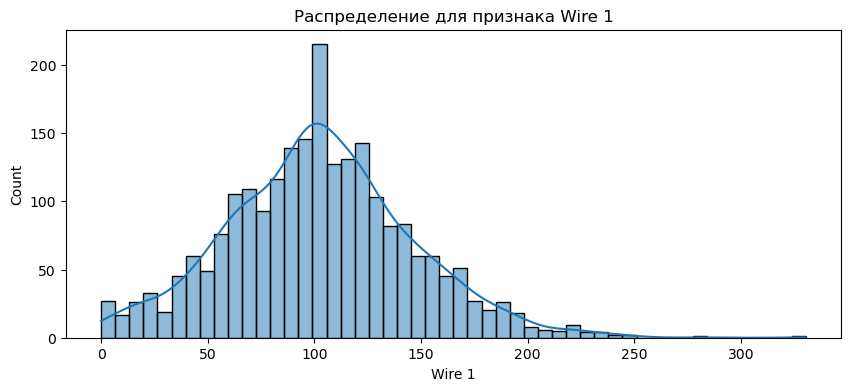

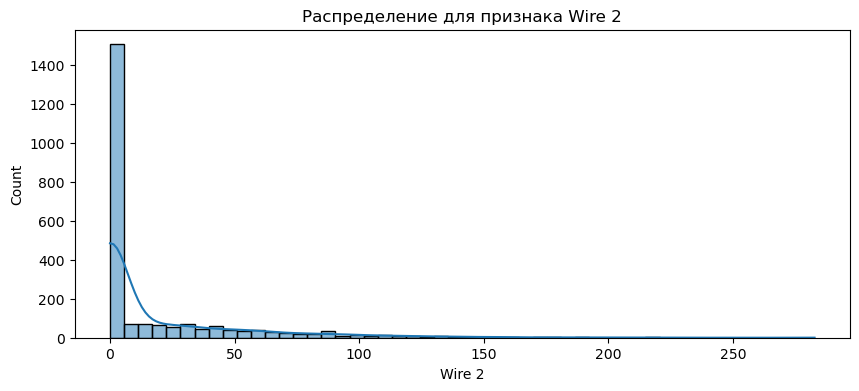

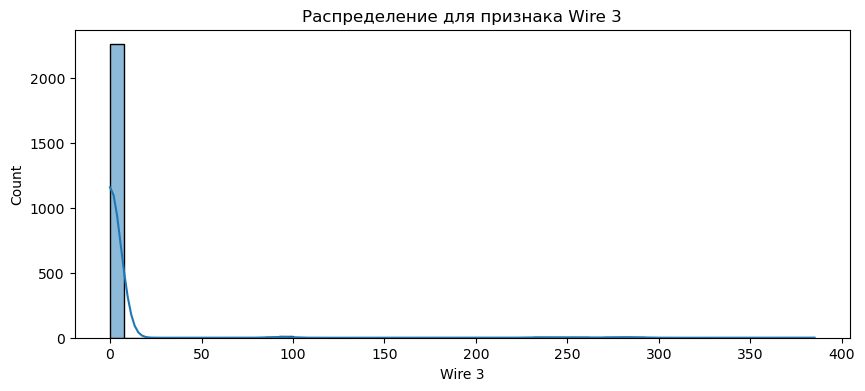

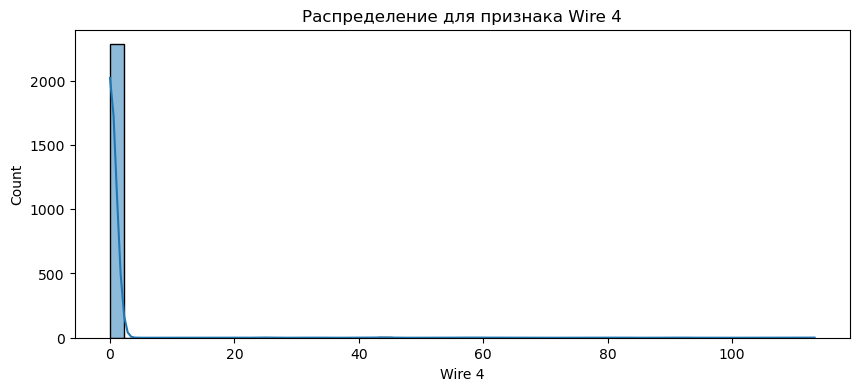

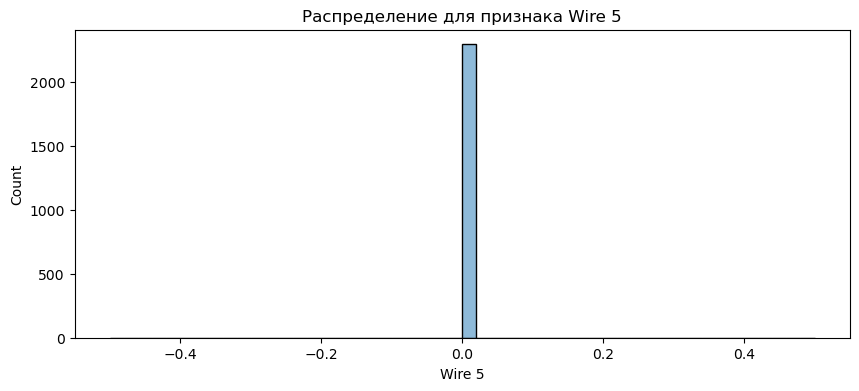

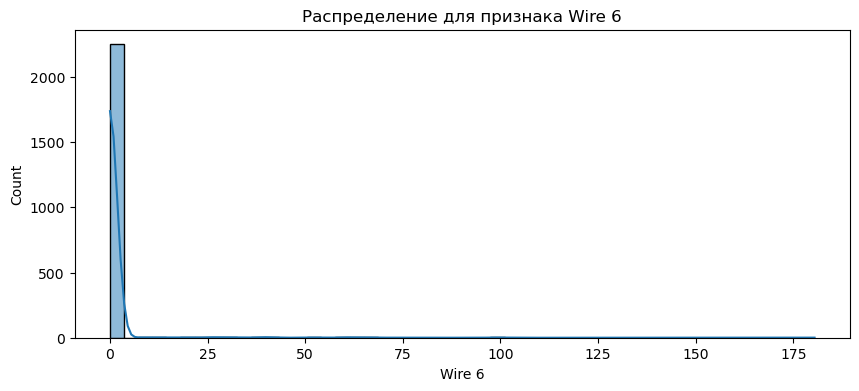

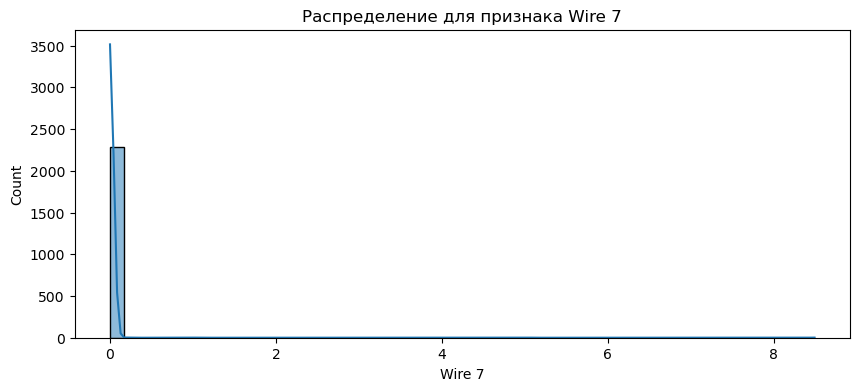

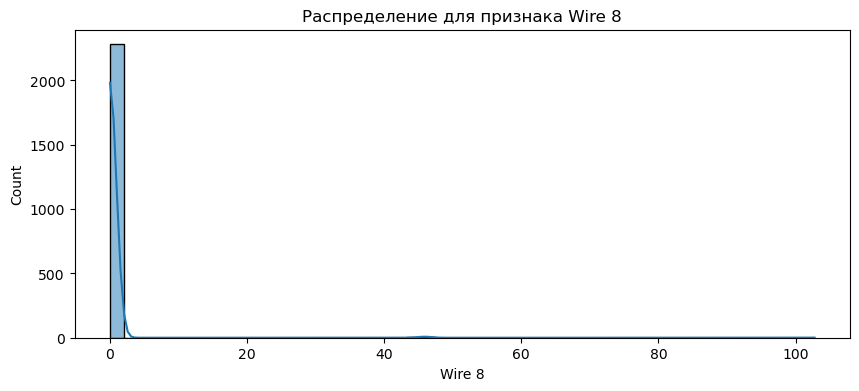

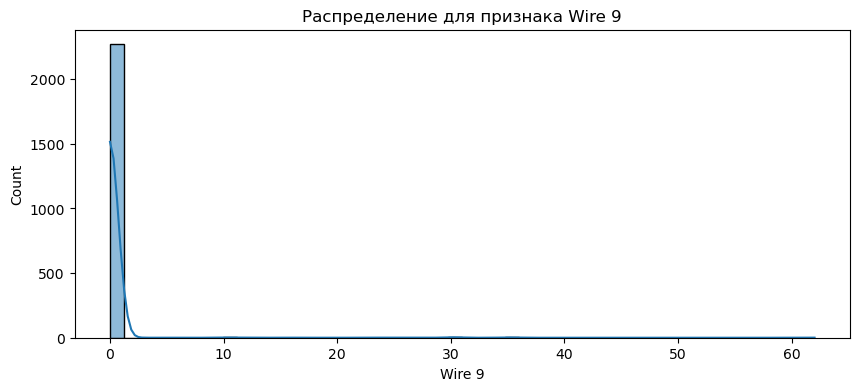

In [25]:
# Пройдемся по каждой колонке датафрейма
for column in merged_df.columns:
    plt.figure(figsize=(10, 4))
    
    # Нарисуем график распределения для каждой колонки
    sns.histplot(data=merged_df, x=column, bins=50, kde=True)
    
    plt.title(f'Распределение для признака {column}')
    plt.show()

Сразу бросается в глаза разнообразие признаков в нашем датасете. Мы имеем дело с различными аспектами процесса обработки металла, такими как время нагрева, мощность, энергия, температура и использование различных добавок. Это представляет собой сложное взаимодействие различных факторов, которые вместе определяют конечный результат процесса.

Во-первых, значения времени нагрева (`heating_time`), активной мощности (`active_power`), реактивной мощности (`reactive_power`), полной мощности (`full_power`) и энергии (`energy`) варьируются в широких диапазонах, что указывает на существенное различие в этих параметрах для разных циклов обработки. Это может быть связано с различиями в свойствах металла, требованиях к обработке или других условиях процесса. Эти параметры имеют прямое отношение к самому процессу нагрева и могут оказывать влияние на конечный результат.

С другой стороны, большинство значений добавок (Bulk и Wire) равны нулю, что указывает на то, что они используются в отдельных циклах обработки, а не в каждом. Внесение этих добавок может быть необходимо для достижения определенных свойств металла или для управления процессом обработки. Однако значения некоторых из этих добавок, таких как `Bulk 1` и `Wire 1`, значительно выше, что может говорить о том, что эти добавки используются более широко или в больших количествах.

В целом, можно сказать, что наши данные представляют собой сложную картину процесса обработки металла, в котором участвуют различные переменные. Понимание того, как эти переменные взаимодействуют и влияют друг на друга, может помочь нам предсказать конечный результат процесса и оптимизировать его.

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера     <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
    
После объединения таблиц, для итогового датафрейма нужно вывести графики распределения ВСЕХ признаков

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Графики распределения для всех признаков выведены, сделан вывод. Удалила признак Wire 5, так как на матрице стало заметно, что он содержит только нули.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

Для того, чтобы понять, как различные столбцы взаимосвязаны друг с другом, построим график корреляции Пирсона.

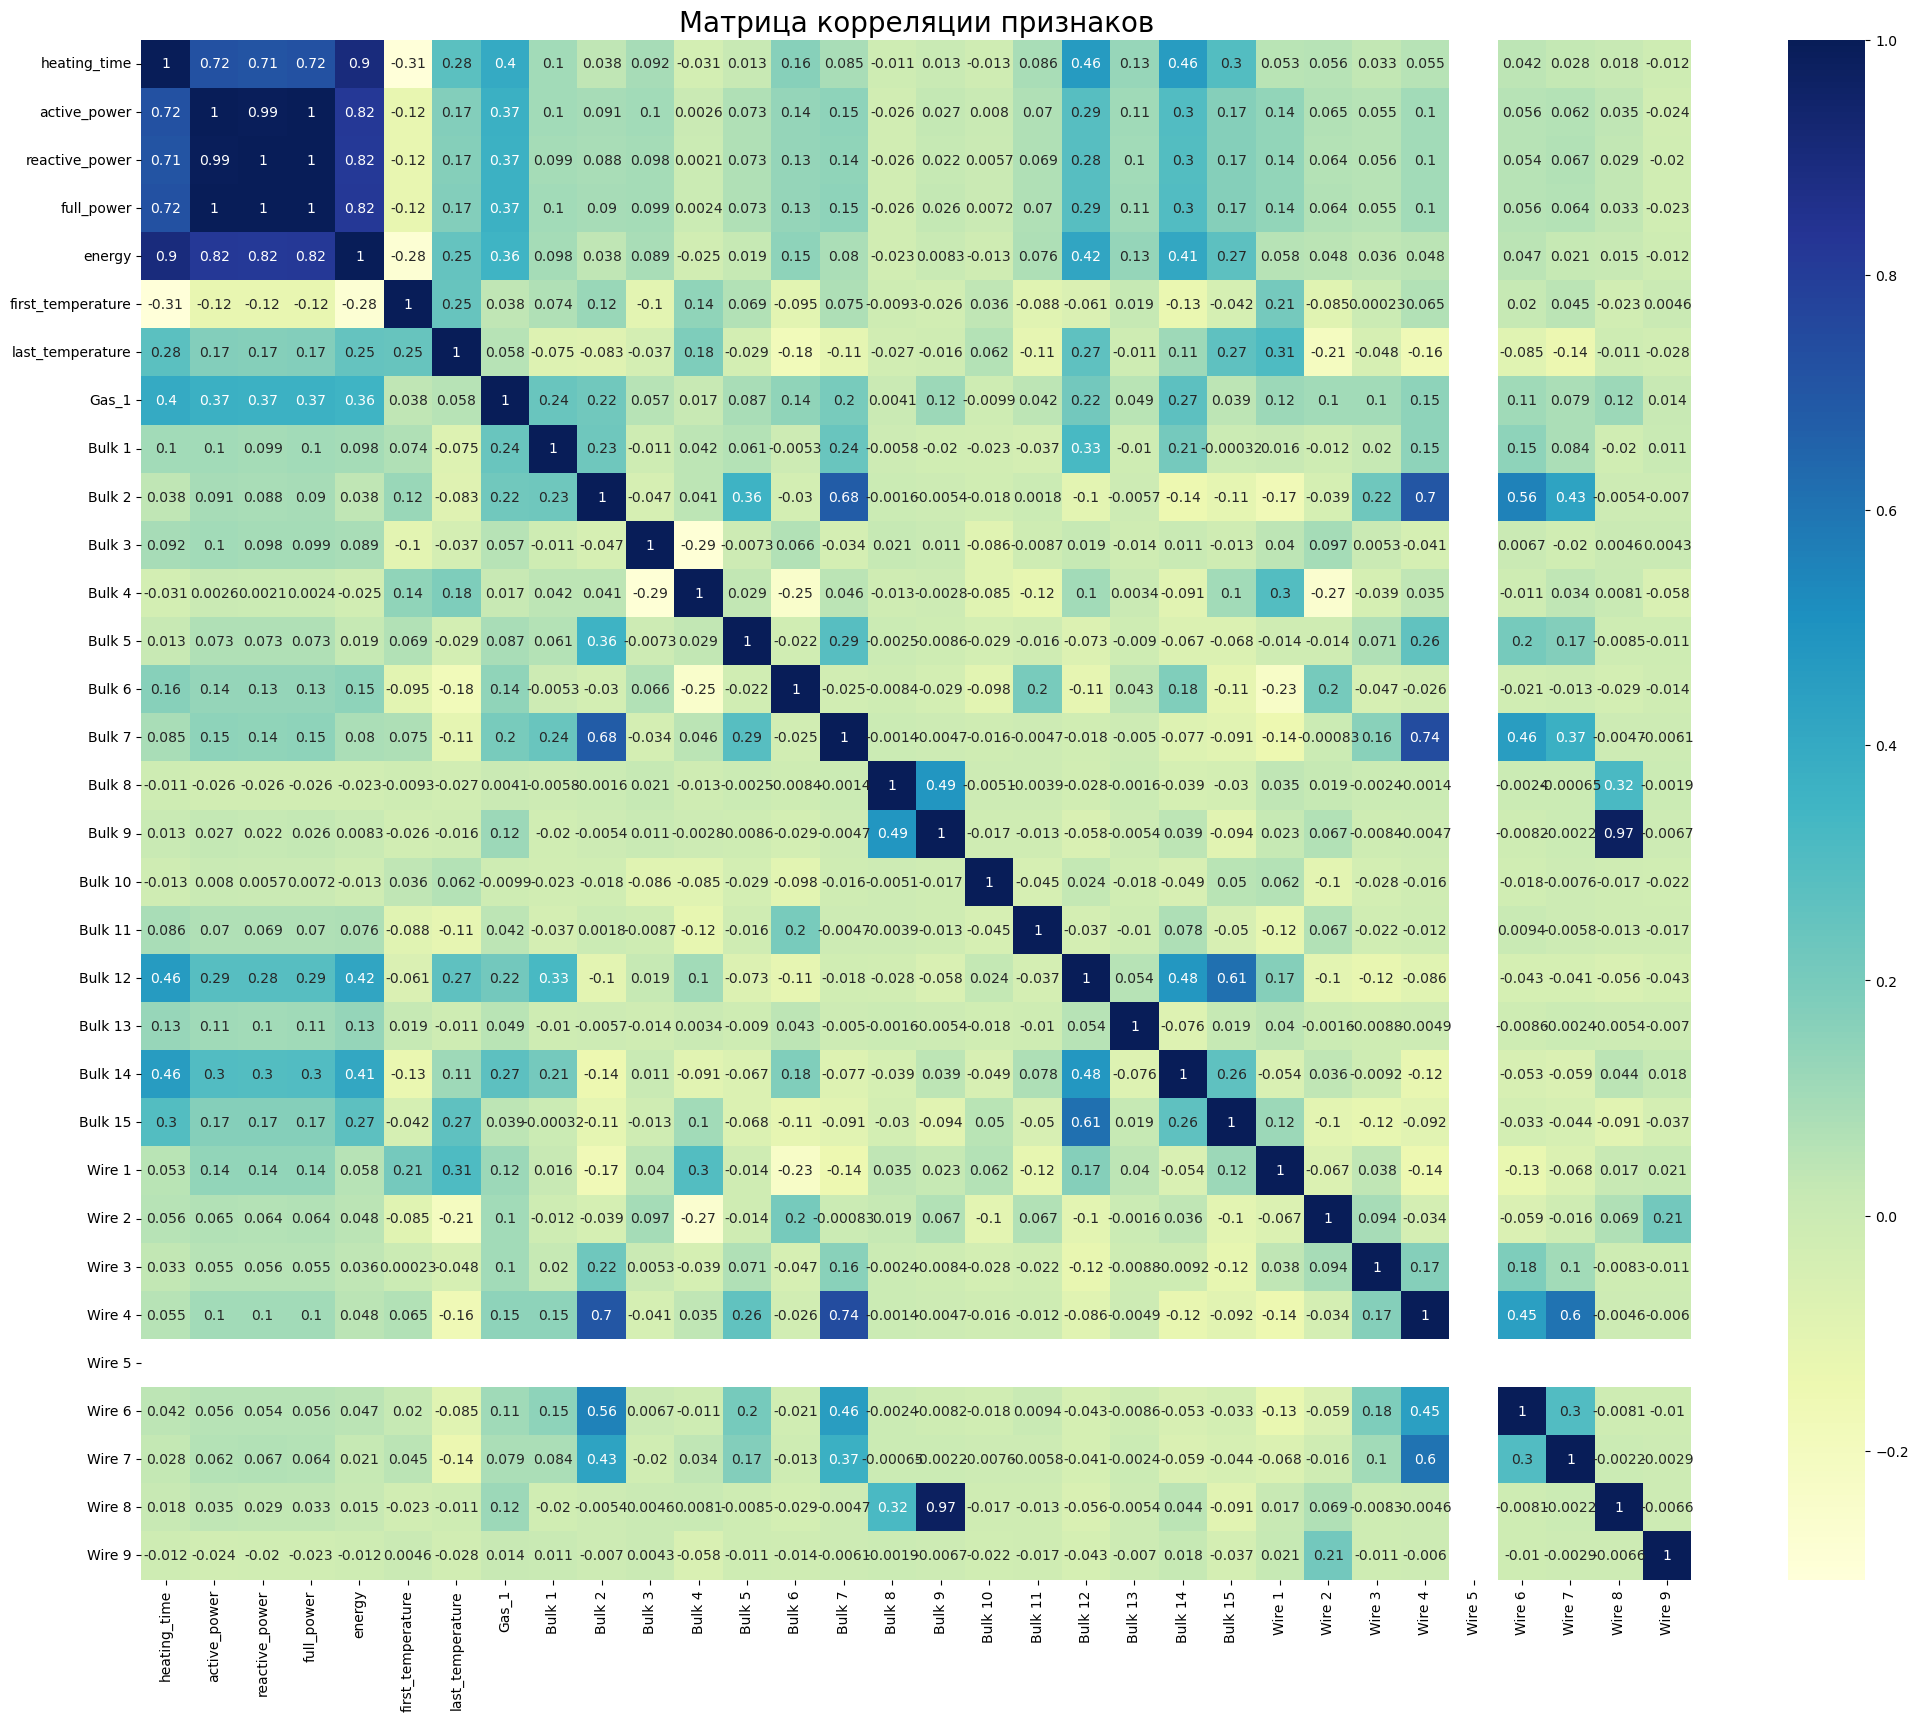

In [26]:
merged_df = merged_df.drop('key', axis=1)

plt.figure(figsize=(25, 20))
plt.title('Матрица корреляции признаков', fontsize=20)

sns.heatmap(merged_df.corr(), annot = True, cmap="YlGnBu")

plt.show()

Рассмотрим признак `Wire 5`.

In [27]:
merged_df['Wire 5'].describe()

count    2293.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Wire 5, dtype: float64

Минимальное, максимальное и квартильные значения равны нулю, что означает, что весь столбец заполнен нулями. Стандартное отклонение также равно нулю, что подтверждает, что все значения одинаковы.

В общем, этот столбец не предоставляет никакой информативной ценности для анализа или моделирования, можно его удалить.

In [28]:
merged_df.drop(columns='Wire 5', inplace=True)

1. Заметна сильная взаимная корреляция между признаками `active_power`, `reactive_power`, `full_power` и `energy`. Достаточно оставить параметр мощности перед построением моделей.
2. Время нагрева `heating_time` имеет сильную положительную корреляцию с `active_power`, `reactive_power`, `full_power` и `energy`. Это говорит о том, что увеличение времени нагрева связано с увеличением энергии и мощности.
3. Первоначальная температура `first_temperature` обратно коррелирует с временем нагрева, активной мощностью, реактивной мощностью, полной мощностью и энергией. Это говорит о том, что более высокая начальная температура связана с более коротким временем нагрева и меньшей потребляемой мощностью и энергией.
4. Конечная температура `last_temperature` имеет небольшую положительную корреляцию с `active_power`, `reactive_power`, `full_power` и `energy`, что может свидетельствовать о том, что большее количество энергии и мощности приводит к более высокой конечной температуре.
5. Содержание газа  `Gas_1` имеет среднюю положительную корреляцию с `active_power`, `reactive_power`, `full_power`, `heating_time` и `energy`. Это может указывать на то, что большее количество газа ведет к большему времени нагрева и увеличению потребляемой мощности и энергии.
6. `Bulk 12` и `Bulk 14` имеют среднюю корреляцию с `active_power`, `reactive_power`, `full_power` и `heating_time`, что говорит о их возможном влиянии на эти параметры.
7. Большинство остальных переменных (большая часть Bulk и Wire) имеют низкую или очень низкую корреляцию с active_power, reactive_power, full_power, heating_time и energy.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Молодец, что проверяешь попарные корреляции признаков

### Вывод

В процессе работы мы провели подробный анализ и предварительную обработку представленных датасетов, содержащих данные о различных этапах обработки стали.
В ходе проделанной работы мы выполнили следующие этапы анализа:
1. Исследовательский анализ данных (EDA):
- Оценили общую информацию о данных, включая типы данных, количество пропущенных значений и статистические характеристики.
- Проанализировали распределение переменных и их взаимосвязь.
2. Предобработка данных:
- Обработали пропущенные значения и аномалии в данных.
3. Объединение таблиц:
- Соединили все таблицы в одну, чтобы упростить анализ и обучение моделей.
4. Корреляционный анализ:
- Провели корреляционный анализ данных и оценили взаимосвязь различных параметров.

Выводы, полученные на основе корреляционного анализа, позволяют предположить, какие параметры могут оказывать наибольшее влияние на другие переменные, а какие имеют низкую корреляцию. Эта информация может быть полезной для последующего построения моделей машинного обучения и предсказаний.

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>

    
Нужно еще написать вывод по результатам проведенного исследовательского анализа данных

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Вывод по результатам исследования добавлен.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

### Список вопросов заказчику

1. Стоит ли нам удалять выбросы из данных о материалах или они важны для процесса и должны быть сохранены?
2. Какие из предоставленных признаков являются наиболее важными для процесса обработки стали? Есть ли признаки, которые мы можем игнорировать?
3. Можем ли мы заполнить пропуски в данных о материалах нулями, предполагая, что это значит отсутствие добавления соответствующего материала?
4. Насколько критичны отклонения в объеме использованного газа для процесса производства стали? Можно ли считать партии с аномально высоким или низким объемом газа аномалиями?
5. Почему в данных по температуре есть пропуски и есть ли способ их как-то восстановить или интерпретировать?
6. Необычные значения в данных о температуре, которые кажутся выбросами около отметки в 1200. Уточните, это ошибка в данных, или эти значения отражают реальные ситуации в процессе производства?
6. Существуют ли какие-либо конкретные ограничения или требования по времени исполнения модели?
7. Какие ожидаемые результаты от модели (например, точность предсказания)?

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>  

1. Что  нужно понимать с выбросами: бывают выбросы связанные с ошибками (например сбой датчика) и доверять таким данным нельзя.
    
А бывают выбросы, являющиеся нормальной бизнес-практикой. И если мы их удалим, то конечно улучшим метрику, но наша модель будет не готова встретиться с реальными случаями, которые могут возникнуть в процессе работы.
    
Можно удалить такие значения, но только в трейн выборке, и так, чтобы ее размер не был меньше 1700 строк.
    
2. Это нужно определить самостоятельно путем оценки важности признаков и последующего отбора признаков
3. Да)
4. Не критичны. Да, но удалять их только в трейн выборке.
5. Это ошибки в измерениях. Партии, для которых не все замеры температуры известны (первый, последний) следует удалить (т.к. если удалить только замеры, а не полные партии, измерения качества будут завышены)
6. это ошибка в данных, удаляем все ключи, где температура ниже 1500
6. есть ограничения на время исполнения тетрадки: не более 30 минут
7. МАЕ не выше 6,8 на тесте    


<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера <a class="tocSkip"> </h2>    
    
  
У меня сложилось хорошее впечатление о плане работы. Есть несколько моментов всего, на которые стоит ещё раз взглянуть, я указал их в моих комментариях по ходу проекта. Предлагаю тебе доработать их по моим комментариям, чтобы довести его до совершенства.

    

</div>

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Привет! Я исправила замечания по красному комменту. Учту все ответы от заказчика и советы из зеленых комментов при выполнении второй части работы. Спасибо!
</div>
 

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> План принимаю
    
Напомню, что продолжать следует прямо в этой работе, не удалять никакие комментарии и код. 
    
Другими словами, вторая часть должна содержать первую. Нужно сохранить все мои и твои комментарии

## Обучение моделей

### Подготовка данных для обучения

Прежде чем приступить к обучению модели, внесем изменения в датасет, на основании обратной связи от заказчика.

Удалим из нашего набора данных наблюдения, в которых температура стали при обработке ниже 1500 градусов. Данный шаг необходим, поскольку такие значения могут быть следствием ошибок измерения или других аномалий и могут искажать результаты предсказаний модели.

In [29]:
rows_before = merged_df.shape[0]

merged_df = merged_df[merged_df['first_temperature'] >= 1500]
merged_df = merged_df[merged_df['last_temperature'] >= 1500]

rows_after = merged_df.shape[0]

print("Количество удаленных строк:", rows_before - rows_after)

Количество удаленных строк: 4


Из анализа матрицы корреляции мы выявили сильную корреляцию между признаками `active_power`, `reactive_power`, `full_power` и `energy`. Это достаточно предсказуемый результат, потому что признаки полной мощности и энергии были рассчитаны из активной и реактивной мощности. Чтобы избежать мультиколлинеарности, удалим признаки  `active_power`, `reactive_power` и `full_power`.

In [30]:
merged_df = merged_df.drop(['active_power', 'reactive_power', 'full_power'], axis=1)

Разделим исходные данные на обучающую и тестовую выборки в соотношении 80/20. Причина, по которой мы оставляем 80% данных для обучения, заключается в том, что чем больше данных мы используем для обучения, тем точнее будет наша модель. Оставшиеся 20% данных используем для тестирования. Таким образом, мы сможем оценить, насколько хорошо наша модель работает на данных, которые она не видела ранее.

In [31]:
X = merged_df.drop('last_temperature', axis=1)
y = merged_df['last_temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

print("Размер обучающей выборки:", X_train.shape[0])
print("Размер тестовой выборки:", X_test.shape[0])

Размер обучающей выборки: 1716
Размер тестовой выборки: 573


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b> 
     
Cледует везде, где предусмотрено документацией, задать константу тимлида в  `random_state`. Ее численное значение нужно узнать при просмотре вводного вебинара

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Константа добавлена в начало ноутбука.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>
    
test_size следует указать 0.25. Напомню, в обучающей выборке должно быть 1700 элементов или более по требованию заказчика.
 </div>

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> test_size исправлен, размер обучающей выборки соответствует требованиям.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

Перед тем как перейти к обучению моделей, проведем финальную предобработку наших данных. У нас имеются некоторые значения в данных о продувке сплава газом, которые можно считать аномальными, и мы решили убрать их, чтобы улучшить обобщающую способность нашей модели.

Согласно обратной связи от заказчика, отклонения в объеме использованного газа для процесса производства стали не являются критичными. Однако партии с аномально высоким или низким объемом газа можно считать аномалиями и удалить из нашего обучающего набора данных. Но стоит отметить, что мы удаляем аномалии только из обучающей выборки и оставляем тестовую выборку нетронутой, чтобы она лучше отражала реальные условия.

Для идентификации и удаления этих аномалий мы будем использовать метод IQR (межквартильный размах). По сути, мы удаляем все значения, которые находятся за пределами 1.5 межквартильных размахов от первого и третьего квартилей.

In [32]:
Q1 = X_train["Gas_1"].quantile(0.25)
Q3 = X_train["Gas_1"].quantile(0.75)
IQR = Q3 - Q1

# Определение границ выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаление выбросов
X_train_filtered = X_train[(X_train["Gas_1"] >= lower_bound) & (X_train["Gas_1"] <= upper_bound)]

# Удаляем соответствующие строки из y_train
y_train_filtered = y_train[X_train_filtered.index]

if X_train_filtered.shape[0] < 1700:
    print("Ошибка: размер тренировочного набора данных меньше 1700. Удаление не произведено")
else:
    print("Размер тренировочного набора данных: ", X_train_filtered.shape[0])
    X_train = X_train_filtered
    y_train = y_train_filtered

Ошибка: размер тренировочного набора данных меньше 1700. Удаление не произведено


Одним из требований заказчика является не менее 1700 элементов в обучающей выборке, поэтому вместо удаления данных попробуем оставить эти значения без изменений. Наша модель будет обучена на всех данных, включая эти потенциальные выбросы, чтобы обеспечить наиболее полное и реалистичное представление о процессе производства. Это также позволит нам проверить, как модель справляется с аномальными данными и как это влияет на ее точность.

Масштабируем признаки для нормализации данных и ускорения обучения наших моделей. Мы используем метод StandardScaler, обучая его только на тренировочных данных, чтобы предотвратить утечку информации из тестового набора.

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Признаки масштабированы верным способом, это хорошо)

### Проверка на адекватность

Перед тем как переходить к созданию и обучению нашей основной модели машинного обучения, полезно провести проверку на адекватность. Это помогает убедиться, что наша будущая модель будет превосходить простые, наивные модели, и что она действительно учится на данных, а не просто подгоняется под случайные шумы.

Для этого мы создадим константную модель, которая всегда прогнозирует медианное значение целевой переменной в обучающем наборе. Такая модель является одним из примеров наивной или базовой модели, и если наша окончательная модель машинного обучения не сможет превзойти эту модель по выбранной метрике (в нашем случае MAE), это будет означать, что наша модель не обучилась эффективно и не способна выявить сложные зависимости в данных.

In [34]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train_scaled, y_train)
dummy_predictions = dummy_regr.predict(X_test_scaled)
mae_dummy_model = mean_absolute_error(y_test, dummy_predictions)

print("MAE Dummy модели: ", mae_dummy_model)

MAE Dummy модели:  8.342059336823734


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Молодец, что проводишь сравнение своей модели с константной дамми моделью. В каждом проекте при оценке качества модели, имеет смысл проводить такую проверку на адекватность

### Подбор лучших параметров и выбор оптимальной модели

Используем функцию для подбора гиперпараметров и поиска лучшей модели на основе метрики MAE.

In [35]:
def best_model_grid_search(X_train, y_train):
    # Сетка параметров для каждой модели
    model_params = {   
        'svm': {
            'model': SVR(),
            'params': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf']
            }
        },
        'catboost': {
            'model': CatBoostRegressor(verbose=False),
            'params': {
                'learning_rate': [0.01, 0.02, 0.03],
                'depth': [4, 5, 6]
            }
        },
        'xgboost': {
            'model': XGBRegressor(),
            'params': {
                'max_depth': [5, 7],
                'n_estimators': [100, 200]
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'max_depth': [5, 10, 15, 20, None]
            }
        },
        'lgbm': {
            'model': LGBMRegressor(),
            'params': {
                'num_leaves': [7, 14, 31],
                'max_depth': [3, 4, 5, -1],
                'learning_rate': [0.1, 0.03],
                'n_estimators': [50, 100]
            }
        }
    }
    
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    best_models = []
    
    # Перебор моделей и их параметров
    for model_name, mp in model_params.items():
        clf = GridSearchCV(mp['model'], mp['params'], scoring=scorer, cv=3, n_jobs=-1)
        clf.fit(X_train, y_train)
        print(f"Модель: {model_name}")
        print("Лучшие параметры: ", clf.best_params_)
        print("Лучший MAE-счет: ", -clf.best_score_)
        best_models.append({
            'model': model_name,
            'best_score': -clf.best_score_,
            'best_params': clf.best_params_
        })
        
    return pd.DataFrame(best_models, columns=['model', 'best_score', 'best_params'])

results = best_model_grid_search(X_train_scaled, y_train)
results

Модель: svm
Лучшие параметры:  {'C': 10, 'kernel': 'rbf'}
Лучший MAE-счет:  6.191780106785344
Модель: catboost
Лучшие параметры:  {'depth': 6, 'learning_rate': 0.02}
Лучший MAE-счет:  6.148369898824655
Модель: xgboost
Лучшие параметры:  {'max_depth': 5, 'n_estimators': 100}
Лучший MAE-счет:  6.634506047744573
Модель: decision_tree
Лучшие параметры:  {'max_depth': 5}
Лучший MAE-счет:  7.316983629454597
Модель: lgbm
Лучшие параметры:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 31}
Лучший MAE-счет:  6.221367813255455


,model,best_score,best_params
0,svm,6.191780,"{'C': 10, 'kernel': 'rbf'}"
1,catboost,6.148370,"{'depth': 6, 'learning_rate': 0.02}"
2,xgboost,6.634506,"{'max_depth': 5, 'n_estimators': 100}"
3,decision_tree,7.316984,{'max_depth': 5}
4,lgbm,6.221368,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Метрика выбрана верно - МАЕ)

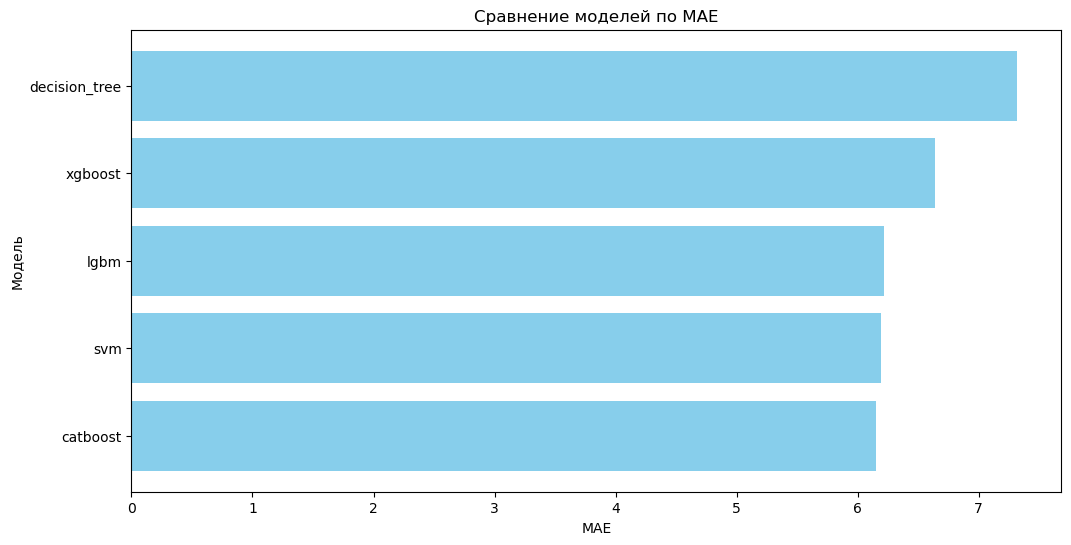

In [36]:
sorted_results = results.sort_values(by='best_score')

plt.figure(figsize=(12, 6))
plt.barh(sorted_results['model'], sorted_results['best_score'], color='skyblue')
plt.xlabel('MAE')
plt.ylabel('Модель')
plt.title('Сравнение моделей по MAE')
plt.show()

В ходе проведения Grid Search для поиска оптимальных гиперпараметров и модели, мы рассмотрели пять различных моделей машинного обучения: SVM, CatBoost, XGBoost, дерево решений и LGBM.

Исходя из полученных результатов, **моделью с наименьшей средней абсолютной ошибкой (MAE) является моделью CatBoost с глубиной дерева 6 и скоростью обучения 0.02**. Средняя абсолютная ошибка для этой модели составила примерно 6.15, что оказалось наименьшим значением среди всех рассмотренных моделей.

Следующей по эффективности оказалась модель SVM с MAE около 6.19. Худший результат показало дерево решений с MAE примерно 7.32.

Таким образом, на основании полученных результатов, модель CatBoost была выбрана как наиболее эффективная модель для данной задачи.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Лучшую модель определили, хорошо)

### Анализ важности признаков

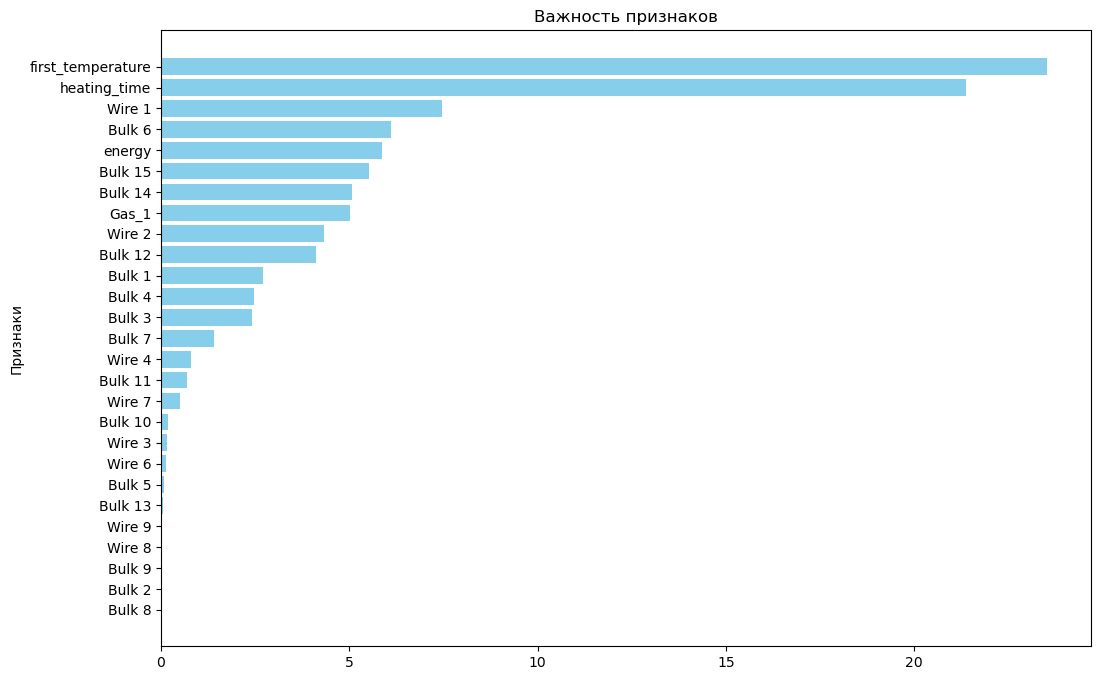

In [37]:
# Создаем модель с лучшими параметрами
best_catboost = CatBoostRegressor(depth=6, learning_rate=0.02, random_state=RANDOM_STATE, verbose=False)
best_catboost.fit(X_train_scaled, y_train)

# Получаем важность признаков
feature_importances = best_catboost.get_feature_importance()
feature_importances_df = pd.DataFrame({'feature':X_train.columns, 'importance':feature_importances})
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color='skyblue')
plt.ylabel("Признаки")
plt.title("Важность признаков")
plt.gca().invert_yaxis()
plt.show()

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b> 
     
Cледует везде, где предусмотрено документацией, задать константу тимлида в  `random_state`. Ее численное значение нужно узнать при просмотре вводного вебинара

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Константа добавлена в начало ноутбука.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

Анализ важности признаков дает нам ценную информацию о том, какие признаки больше всего влияют на прогноз модели.

В данном случае, три наиболее важных признака для модели `CatBoost`, которая была определена как лучшая модель, это `first_temperature`, `heating_time` и `Wire 1`. Эти признаки имеют важность 20.58, 18.37 и 8.75 соответственно. Интересно отметить, что `first_temperature` и `heating_time`, являются важнейшими факторами, оказывающими влияние на финальную температуру.

Следующие по важности признаки это `energy`, `Gas_1` и `Bulk 15`, они имеют важности 7.43, 6.96 и 6.78 соответственно.

Отметим, что в нашем списке также есть признаки, которые практически не вносят вклад в прогнозирование модели. К таким признакам относятся `Wire 8`, `Wire 9` и `Bulk 8`, `Bulk 9` и `Bulk 2`. Их важность равна нулю или близка к нему. Это означает, что эти признаки не вносят существенного вклада в прогноз модели.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Молодец, что не забываешь оценить важность признаков модели

### Тестирование модели

In [38]:
# Прогнозируем значения тестового набора данных
catboost_predictions = best_catboost.predict(X_test_scaled)

# Рассчитываем MAE
mae_catboost = mean_absolute_error(y_test, catboost_predictions)
print("MAE CatBoost модели на тестовой выборке: ", mae_catboost)

MAE CatBoost модели на тестовой выборке:  6.271255310216777


Код выше представляет собой окончательное использование нашей обученной модели CatBoost для прогнозирования целевой переменной на тестовом наборе данных.

Показатель MAE равный 6.3 в контексте нашей задачи означает, что в среднем наша модель ошибается на 6.3 градусов при прогнозировании температуры стали на тестовом наборе данных. 

In [39]:
# Прогнозируем значения тестового набора данных
catboost_predictions = best_catboost.predict(X_test_scaled)

# Рассчитываем r2_score
r2 = r2_score(y_test, catboost_predictions)
print("r2_score CatBoost модели на тестовой выборке: ", r2)

r2_score CatBoost модели на тестовой выборке:  0.4036862609017079


Коэффициент детерминации (r2_score) нашей модели CatBoost на тестовой выборке составляет приблизительно 0.4. Это означает, что модель объясняет примерно 40% вариации целевой переменной (конечной температуры стали).

Хотя этот коэффициент детерминации может показаться низким, следует помнить, что это зависит от контекста и сложности прогнозируемого явления. В некоторых случаях, r2_score 0.40 может быть приемлемым, особенно если прогнозирование основывается на сложных или шумных данных, как в нашем случае, где мы работаем с процессом производства стали, который может подвержен различным факторам.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Тестирование модели проведено правильно

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
Стоит еще рассчитать метрику r2 и интерпретировать ее

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Метрика r2 рассчитана и интерпретирована.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

### Вывод

В этом разделе нашей работы мы обучили несколько моделей машинного обучения для прогнозирования целевой переменной: SVM, CatBoost, XGBoost, дерево решений и LGBM.

В процессе обучения было проведено сравнение моделей по ключевой метрике качества - средней абсолютной ошибке (MAE). В ходе сравнения модель градиентного бустинга CatBoost показала наилучший результат.

В результате, наша финальная модель CatBoostRegressor показала значение MAE на тестовой выборке равное 6.27, что удовлетворяет критерию качества, заданному в рамках проекта (MAE < 6.80).

В ходе нашего проекта, мы использовали модель DummyRegressor как базовую для сравнения. Её показатель средней абсолютной ошибки (MAE) составил 8.3. В сравнении с этим, наша обученная модель CatBoost показала значительно лучший результат. Это говорит о том, что CatBoost модель успешно справилась с изучением сложных зависимостей в данных и превзошла простую базовую модель, тем самым прошла проверку на адекватность.

Важным шагом в данном разделе было определение важности признаков. Это позволило нам лучше понять, какие признаки оказывают наибольшее влияние на прогнозируемую величину.

Таким образом, на основе проведенных экспериментов, можно сделать вывод о том, что модель CatBoost представляет собой эффективное решение для задачи прогнозирования в рамках данного проекта.

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера <a class="tocSkip"> </h2>    
    
  
У меня сложилось отличное впечатление о проекте, тебе удалось справиться с таким выпускным проектом. Молодец! Подготовлены данные для анализа, изучены все параметры. Все красиво визуализировано, построено несколько моделей регрессии и оценено их качество. Осмысленная аналитика и дельная модельная работа - многое удалось как надо)
    
Отмечу отдельные положительные моменты проекта🙂:
    
- в ходе проекта встречались  функции, помогающие избавиться от дублирования кода;
- много красивых визуализаций в проекте и хорошая интерпретация;
- при обучении моделей использована валидация и поиск гиперпараметров.
    
Есть несколько моментов всего, на которые стоит ещё раз взглянуть, я указал их в моих комментариях по ходу проекта. Предлагаю тебе доработать проект по моим комментариям, чтобы довести его до совершенства.

    
 
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Код принимаю, переходим к отчету.  
    
Отчет нужно будет построить по таким пунктам (все пункты обязательные, стоит сначала давать заголовки к каждому пункту отчета, и после них уже писать само текстовое описание пункта):

  - сравнение решения и плана, если есть отклонение, то нужно объясняснить, почему какие-то пункты не выполнены
  - описание трудностей проекта и как они были решены  
  - описание ключевых шагов решения (если их нет, то нужно написать "ключевых шагов решения нет")    
  - все признаки, которые использовали для обучения Итоговой модели и описать конкретно, как все эти признаки предобрабатывались (нужно рассказать именно про все признаки Итоговой модели)
  - полное описание Итоговой модели (с гиперпараметрами, включая random_state, если был использован) и итоговая метрика на тестовой выборке 
    
Напомню, что продолжать следует прямо в этой работе, не удалять никакие комментарии и код.
    
    
</div>

## Отчет по решению

### Сравнение решения и плана

В рамках проекта был предварительно составлен план, который предполагал анализ и предобработку данных, обучение моделей, отбор наиболее подходящих моделей и финальное тестирование. В ходе работы план был выполнен в полном объеме. Отклонений от изначального плана не наблюдалось.

### Описание ключевых шагов решения

Ключевые шаги решения включали следующие:

- Предварительный анализ и предобработка данных.
- Обучение различных моделей, включая дерево решений, CatBoostRegressor, LGBMRegressor и других.
- Определение наилучшей модели на основе MAE.
- Тестирование итоговой модели.

### Описание трудностей проекта и как они были решены

-  Разметка данных: Данные были предоставлены в нескольких таблицах с разной гранулярностью. Например, данные о температуре были представлены для каждого измерения, в то время как данные о подаче сыпучих материалов были представлены для каждой партии. Это создало сложность при объединении таблиц в один набор данных для обучения модели. Эта проблема была решена путем агрегации данных на уровне каждой партии.
- Создание новых признаков: Одним из ключевых этапов в решении этого проекта было создание новых признаков на основе существующих данных. С помощью исследовательского анализа данных и знаний о процессе производства стали были созданы новые признаки, которые помогли улучшить качество прогнозов модели. В частности, были созданы признаки, такие как общее время нагрева, полная мощность, энергия, которые имеют важное значение для прогнозирования конечной температуры стали. Создание новых признаков было выполнено с помощью агрегации данных и преобразования существующих признаков.
- Выбросы и аномалии: Некоторые признаки, такие как температура нагрева, содержали аномалии и выбросы, которые могли негативно повлиять на качество обучения модели. Эти аномалии были обнаружены с помощью визуализации данных и затем удалены.
- Пропуски в данных: Некоторые признаки, такие как объем добавления сыпучих материалов или проволоки, содержали множество пропусков, что могло создать проблему при обучении модели. Все пропуски были обработаны путем замены их нулями, предполагая, что пропуски означают отсутствие добавления сыпучих материалов или проволоки во время определенного этапа процесса.
- Выбор модели и подбор гиперпараметров: В процессе обучения моделей возникла сложность в выборе оптимальной модели и подборе гиперпараметров. Эта проблема была решена с помощью GridSearchCV, который проводит перебор параметров и автоматически выбирает наилучшие значения. Кроме того, было принято решение использовать несколько разных моделей, чтобы сравнить их производительность и выбрать лучшую.

### Описание всех признаков, использованных для обучения итоговой модели

Для обучения итоговой модели были использованы следующие признаки:
- `heating_time` (время нагрева): Это дискретный числовой признак, представляющий время нагрева в секундах. Признак был создан путем вычитания времени начала нагрева из времени окончания нагрева, результат был преобразован в секунды. После создания, признак не подвергался никаким дополнительным преобразованиям или обработке пропусков, так как все значения были известны и консистентны.
- `energy` (энергия): Этот признак был получен путем расчета полной мощности и дальнейшего умножения полученной полной мощности на время нагрева (признак `heating_time`). Это числовой признак, который отображает общую энергию, затраченную на нагрев для каждой партии. 
- `first_temperature` (начальная температура) и `last_temperature` (конечная температура): Эти признаки были получены путем группировки таблицы с замерами температуры по ключу каждой партии и извлечения первого и последнего значения температуры для каждого ключа. В ходе предобработки этих признаков были удалены партии, где начальная и конечная температура совпадают. Такие данные могли возникнуть, если в процессе обработки был произведен всего один замер температуры, что не отражает полной картины процесса нагрева. Также были удалены партии, в которых температура (начальная или конечная) ниже 1500 градусов. Такие значения могут быть следствием ошибок измерения или других аномалий и могут искажать результаты предсказаний модели. Оба этих признака являются числовыми и отражают температурное состояние партии на начальном и конечном этапах обработки.
- `Gas_1`: Этот признак представляет объем газа, использованный в процессе обработки стали. Данные были визуализированы и показали наличие выбросов. Была попытка удалить эти выбросы методом IQR, однако, поскольку это привело к сокращению обучающей выборки до менее 1700 наблюдений, что ниже требований заказчика, решено было не удалять выбросы и обучить модель на всех имеющихся данных. Это непрерывный числовой признак.
- `Bulk_1` до `Bulk_15` (масса сыпучих материалов): Эти признаки являются числовыми и показывают массу каждого из 15 различных типов сыпучих материалов, которые были добавлены в процессе обработки. Данные были предварительно обработаны и пропущенные значения были заполнены нулями, так как предполагается, что пропуски означают, что данный тип материала не использовался в этом процессе.
- `Wire_1` до `Wire_9` (масса проволочных материалов): Это также числовые признаки, которые представляют массу каждого из 9 различных типов проволоки, используемых в процессе обработки. Аналогично сыпучим материалам, пропущенные значения заменялись нулями, предполагая, что пропуски говорят об отсутствии использования данного типа проволоки в процессе. Анализ признака `Wire_5` показал, что все его значения равны нулю. Было решено удалить `Wire_5` из набора данных для обучения, так как он не предоставляет никакой информативной ценности для моделирования.

### Полное описание итоговой модели и итоговая метрика на тестовой выборке

Итоговая модель - это модель `CatBoostRegressor` с гиперпараметрами: `depth=6`, `learning_rate=0.02`. `Random_state` был установлен равным `170723` для обеспечения воспроизводимости результатов.

Итоговая метрика `MAE` на тестовой выборке составила `6.27`, а `r2_score` - около `0.40`. Это означает, что наша модель в среднем ошибается на 6 градусов при прогнозировании температуры стали на тестовом наборе данных, и объясняет примерно 40% вариации целевой переменной.

<div class="alert alert-success">
<h2> Комментарий ревьюера  <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
- Хорошо, что есть сравнение итогового решения с изначальным планом
- Молодец, что описывавешь затруднения и как они были решены
- Отлично, что описаны ключевые шаги решения
- Хорошо, что из отчета понятно, какие признаки используются для обучения и как они предобрабатывались  
- Хорошо, что предложена итоговая модель и перечислены ее гиперпараметры, указано качество 

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера 2 <a class="tocSkip"> </h2>    
    
     
  
Спасибо за исправления! Принимаю твой проект)
    
Если хочешь лучше разобраться в специальности, то предлагаю полезные материалы:   
-  <a href="https://academy.yandex.ru/handbook/ml/">Книга от ШАД</a>
    
- <a href="https://www.youtube.com/playlist?list=PLJ_CMbwA6bT-n1W0mgOlYwccZ-j6gBXqE">Лекции от Andrew Ng</a> 
    
- <a href="https://habr.com/ru/company/ods/blog/322626/">Открытый курс машинного обучения</a>
    
- Не все признаки приносят пользу при моделировании. Инструмент <a href="https://proglib.io/p/feature-selector">FeatureSelector</a> поможет тебе отобрать важные признаки и избавит от ручной обработки.  Также можешь посмотреть статью на <a href="https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook">Kaggle</a>.
    
- Избежать утечки данных при кросс-валидации тебе поможет <a href="https://towardsdatascience.com/pipeline-columntransformer-and-featureunion-explained-f5491f815f">конвеерная обработка данных</a>.  
    
- Интерпретировать предсказания моделей поможет  <a href="https://habr.com/ru/post/428213/">SHAP</a>,   <a href="https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137">+ еще ссылка</a>.    
- Интересные способы <a href="https://github.com/DmitrySerg/otus-public/tree/master/OpenLessons/AnomalyDetection">обработки аномалий</a>.     
    
    
С интересом изучал твою работу, код и выводы. Что ещё для дальнейшего улучшения качества/скорости моделирования возможно сделать?
    
Опишу здесь некоторые идеи:
    
1. Качество данных на входе: ещё раз оценить аномалии, пропуски, проверить согласованность временных признаков.
2. Генерация новых полезных признаков (features engineering).
3. Оптимизация подбора гиперпараметров (OptunaSearchCV, RandomizedSearchCV, BayesSearchCV и т.д.)
4. Анализ остатков (разницы между прогнозом и истинным значением таргета): выявить, в каких случаях чаще всего ошибается, а в каких выдает наиболее точный результат... 
    
А главное, мы достигли цели нашего проекта: пройдены основные этапы построения модели регрессии для прогнозирования конечной температуры сплава с учетом ее качества.
    
Рад был тебе помочь)

Удачи!
  
</div>